# Анализ данных, связанных с игрой Hearthstone
## Замятин Андрей, 316 группа

Устанавливаем библиотеки Python:

In [ ]:
!pip install pingouin
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.9/198.9 kB 4.1 MB/s eta 0:00:00


In [ ]:
#python
import warnings

import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.contingency_tables import mcnemar
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from pingouin import ttest

from scipy.stats import kstest, shapiro, anderson, cramervonmises, f_oneway, mannwhitneyu, levene, bartlett, fligner, pearsonr, spearmanr, kendalltau, chisquare, fisher_exact, norm

from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

from outliers import smirnov_grubbs

from tensorflow import keras

warnings.filterwarnings('ignore')
sns.set(style="darkgrid")

In [ ]:
# R
%reload_ext rpy2.ipython

Устанавливаем библиотеки и функции R:

In [ ]:
%%R
install.packages("ISwR")
install.packages("pcaPP")
install.packages("reticulate")
install.packages("regclass")
install.packages("coop")
install.packages("car")

(as ‘lib’ is unspecified)







	‘/tmp/RtmpGKhcfT/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmpGKhcfT/downloaded_packages’



In [ ]:
%%R
oldw <- getOption("warn")
options(warn = -1)
set.seed(102030)


library("dplyr")
library("tidyr")
library("mice")
library("nortest")
library("outliers")
library("ISwR")
library("knitr")
library("base")
library("pcaPP")
library("reticulate")
library("corrplot")
library("regclass")
library("glmnet")
library("coop")
library("car")

Данные: "https://omgvamp-hearthstone-v1.p.rapidapi.com"

Данные я собираю вручную и записываю в файл, чтобы прочитать его и для R

In [ ]:
url = "https://omgvamp-hearthstone-v1.p.rapidapi.com/cards/classes/Paladin"

querystring = {"collectible":"1"}

headers = {
	"X-RapidAPI-Key": "b43ec6fb81msh215117f718d0fbep155871jsnb2d192218e2a",
	"X-RapidAPI-Host": "omgvamp-hearthstone-v1.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)



1.   Работать буду с картами существ паладина
2.   Данные содержат и вспомогательные карты для игры, т.е. которые игрок не может сыграть, но они могу появиться каким-либо образом, так что я их удалю
3. Также в данных содержатся карты для другого формата игры, их я тоже удаляю
4. Также удалим ненужные нам столбцы

In [ ]:
Paladin_df = pd.DataFrame(response.json())

Paladin_df = Paladin_df.drop(columns=['artist', 'collectible', 'playerClass', 'locale', 'img',
       'flavor', 'spellSchool', 'text', 'mechanics', 'race',
       'imgGold', 'howToGet', 'howToGetGold', 'durability', 'elite',
       'multiClassGroup', 'classes', 'howToGetSignature', 'howToGetDiamond',
       'otherRaces', 'armor', 'faction'])
Paladin_df = Paladin_df.dropna()
Paladin_df = Paladin_df[Paladin_df["type"] == "Minion"][Paladin_df["cardSet"] != "Unknown"].drop_duplicates(subset=['name'])

In [ ]:
Paladin_df.to_csv("Paladin_df.csv")

In [ ]:
%%R
Paladin_df <- read.csv(file = "./Paladin_df.csv", header = TRUE)
Paladin_df <- na.omit(Paladin_df)

Возьмем базу и для мага, чтобы сравнивать ее существ с существами паладина.

Объясняю свой выбор классов следующим образом:



> Паладин имеет много существ, с малой стоимостью, высокой атакой и низкой выживаемостью, является классом для любителей агрессивной игры со стола (используя крупных существ) и забафов их.

> В то же время маг использует для игры в основном заклинания и ее существа во многом имеют сильные особенности и слабые характеристики.

Сравнивать эти два класса может быть интересным!









In [ ]:
url = "https://omgvamp-hearthstone-v1.p.rapidapi.com/cards/classes/Mage"

response2 = requests.get(url, headers=headers, params=querystring)

In [ ]:
Mage_df = pd.DataFrame(response2.json())

Mage_df = Mage_df.drop(columns=['artist', 'collectible', 'playerClass', 'locale', 'img',
       'flavor', 'spellSchool', 'text', 'mechanics', 'race',
       'imgGold', 'howToGet', 'howToGetGold', 'durability', 'elite',
       'multiClassGroup', 'classes', 'howToGetSignature', 'howToGetDiamond',
       'otherRaces', 'armor', 'faction'])
Mage_df = Mage_df.dropna()
Mage_df = Mage_df[Mage_df["type"] == "Minion"][Mage_df["cardSet"] != "Unknown"].drop_duplicates(subset=['name'])

In [ ]:
Mage_df.to_csv("Mage_df.csv")

In [ ]:
%%R
Mage_df <- read.csv(file = "./Mage_df.csv", header = TRUE)
Mage_df <- na.omit(Mage_df)

Сккачиваю еще одну базу данных, но уже для общих существ. Она будет иметь наибольшее число разнообразных карт, не заточенных ни под один класс.

In [ ]:
url = "https://omgvamp-hearthstone-v1.p.rapidapi.com/cards/classes/Neutral"

response1 = requests.get(url, headers=headers, params=querystring)

In [ ]:
Neutral_df = pd.DataFrame(response1.json())

Neutral_df = Neutral_df.drop(columns=['artist', 'collectible', 'playerClass', 'locale', 'img',
       'flavor', 'spellSchool', 'text', 'mechanics', 'race',
       'imgGold', 'howToGet', 'howToGetGold', 'durability', 'elite',
       'multiClassGroup', 'classes', 'howToGetSignature', 'howToGetDiamond',
       'otherRaces', 'armor', 'faction'])
Neutral_df = Neutral_df.dropna()
Neutral_df = Neutral_df[Neutral_df["type"] == "Minion"][Neutral_df["cardSet"] != "Unknown"].drop_duplicates(subset=['name'])

In [ ]:
Neutral_df.to_csv("Neutral_df.csv")

In [ ]:
%%R
Neutral_df <- read.csv(file = "./Neutral_df.csv", header = TRUE)
Neutral_df <- na.omit(Neutral_df)

Еще одна база данных по драконам.

In [ ]:
url = "https://omgvamp-hearthstone-v1.p.rapidapi.com/cards/races/Dragon"
response3 = requests.get(url, headers=headers)

In [ ]:
Dragon_df = pd.DataFrame(response3.json())

Dragon_df = Dragon_df.drop(columns=['artist', 'collectible', 'playerClass', 'locale', 'img',
       'flavor', 'spellSchool', 'text', 'mechanics', 'race',
       'imgGold', 'howToGet', 'howToGetGold', 'elite',
       'howToGetSignature', 'howToGetDiamond',
       'otherRaces', 'faction', 'runeCost'])

In [ ]:
Dragon_df = Dragon_df.dropna()
Dragon_df = Dragon_df[Dragon_df["type"] == "Minion"][Dragon_df["cardSet"] != "Unknown"][Dragon_df["cardSet"] != "Mercenaries"][Dragon_df["cardSet"] != "Battlegrounds"].drop_duplicates(subset=['name'])

## Трудности работы с моей базой

База данных карт из игры Hearthstone не подходит для некоторых заданий (1 и 12), т.к. в них подразумевается абсолютная непрерывность функции распределения, когда как в моей базе распределение дискретное, т.к. множество возможных здоровья стоимости и атаки ограничено целым числом в пределах 10.

Так что загружаю дополнительную базу данных посетителей магазина в Техассе

In [ ]:
!gdown 1H82_31f3PHPwixpmnIld06jQpNLf3bbm

Downloading...
From: https://drive.google.com/uc?id=1H82_31f3PHPwixpmnIld06jQpNLf3bbm
To: /content/Mall_Customers.csv
100% 4.29k/4.29k [00:00<00:00, 12.4MB/s]


In [ ]:
df = pd.read_csv("Mall_Customers.csv")
df

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [ ]:
%%R
df <- read.csv(file = "Mall_Customers.csv", header = TRUE)
df <- na.omit(df)

    CustomerID  Genre Age Annual.Income..k.. Spending.Score..1.100.
1            1   Male  19                 15                     39
2            2   Male  21                 15                     81
3            3 Female  20                 16                      6
4            4 Female  23                 16                     77
5            5 Female  31                 17                     40
6            6 Female  22                 17                     76
7            7 Female  35                 18                      6
8            8 Female  23                 18                     94
9            9   Male  64                 19                      3
10          10 Female  30                 19                     72
11          11   Male  67                 19                     14
12          12 Female  35                 19                     99
13          13 Female  58                 20                     15
14          14 Female  24                 20    

## №1. Аппроксимация распределений данных с помощью ядерных оценок.

Рассмотрим зависимость суммы атаки от количества затрачиваемой на карту маны

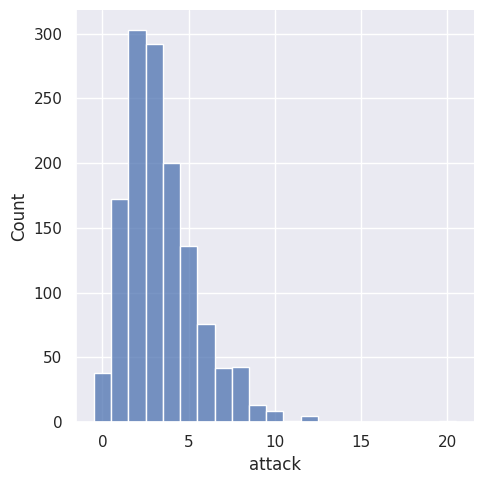

In [ ]:
# Python
sns.displot(
    x = 'attack',
    data = Neutral_df,
    discrete=True
);

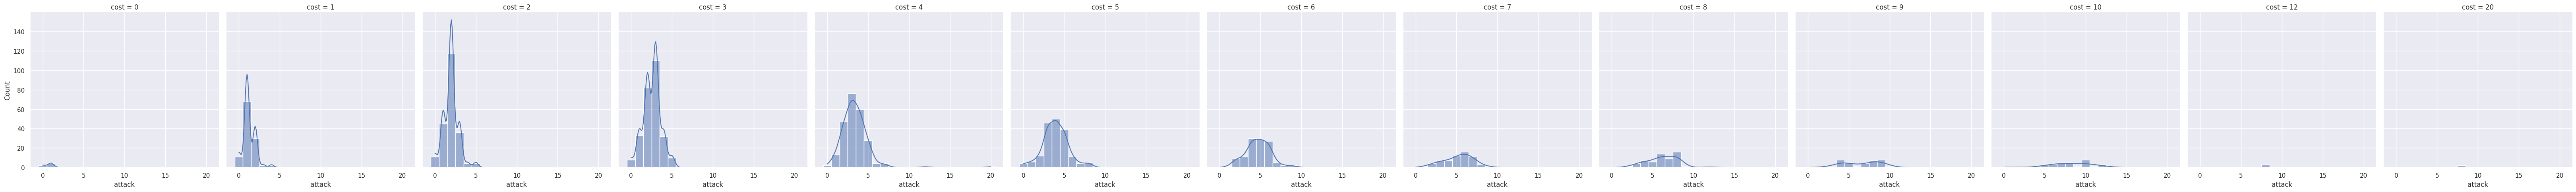

In [ ]:
# Python
sns.displot(
    # data = Neutral_df[Neutral_df["cost"] <= 6],
    data = Neutral_df,
    x = 'attack',
    col = 'cost',
    kde = True,
    discrete=True
);

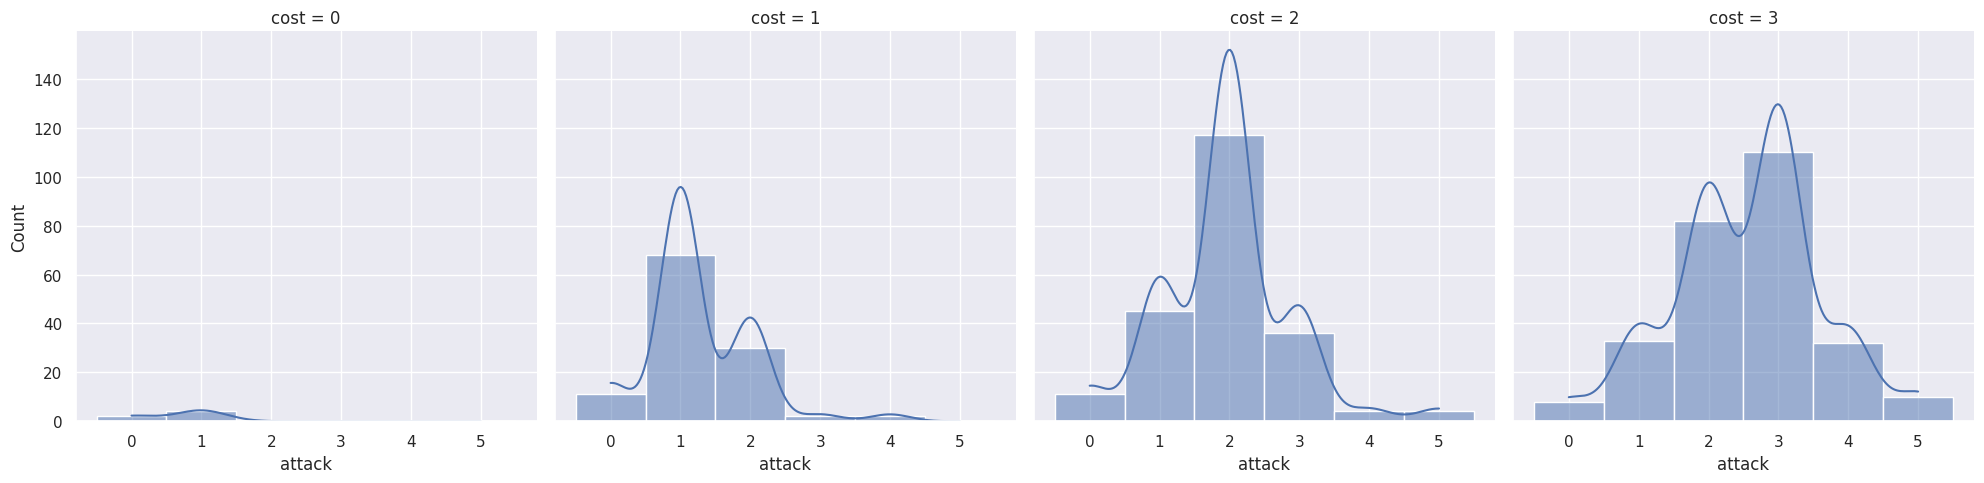

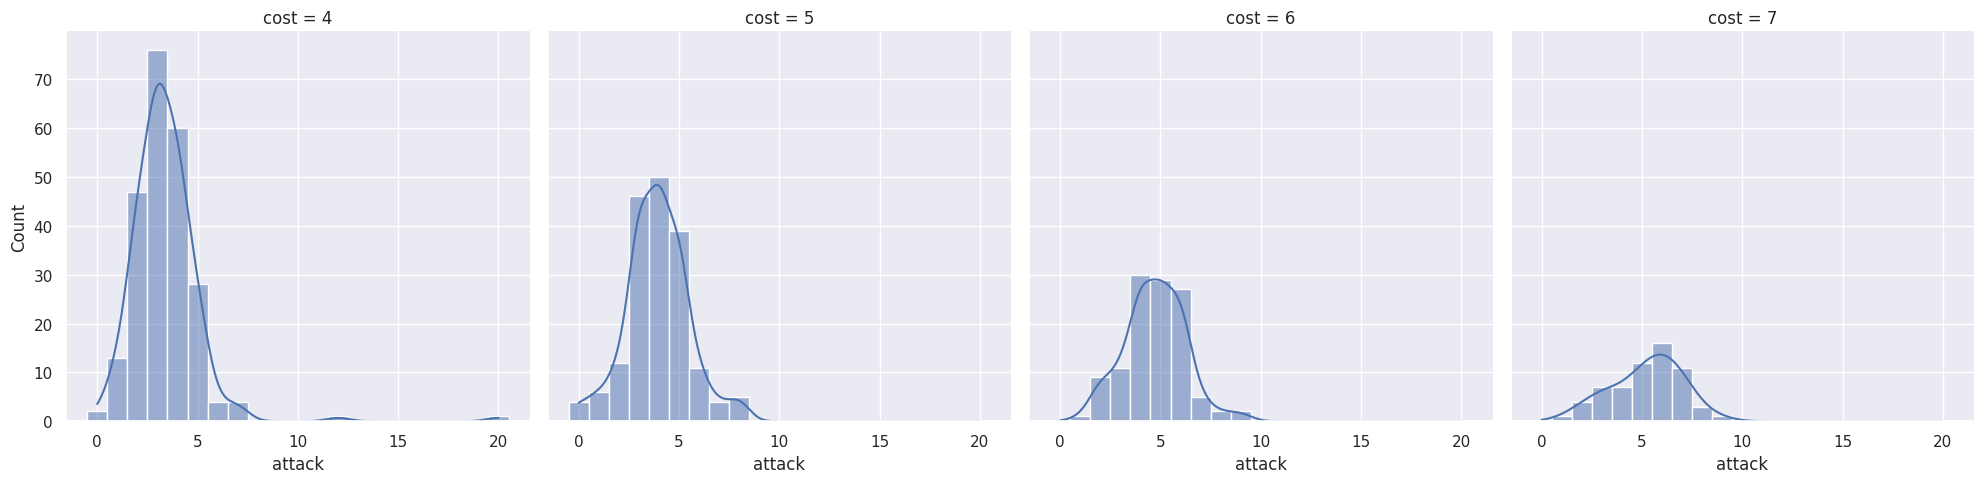

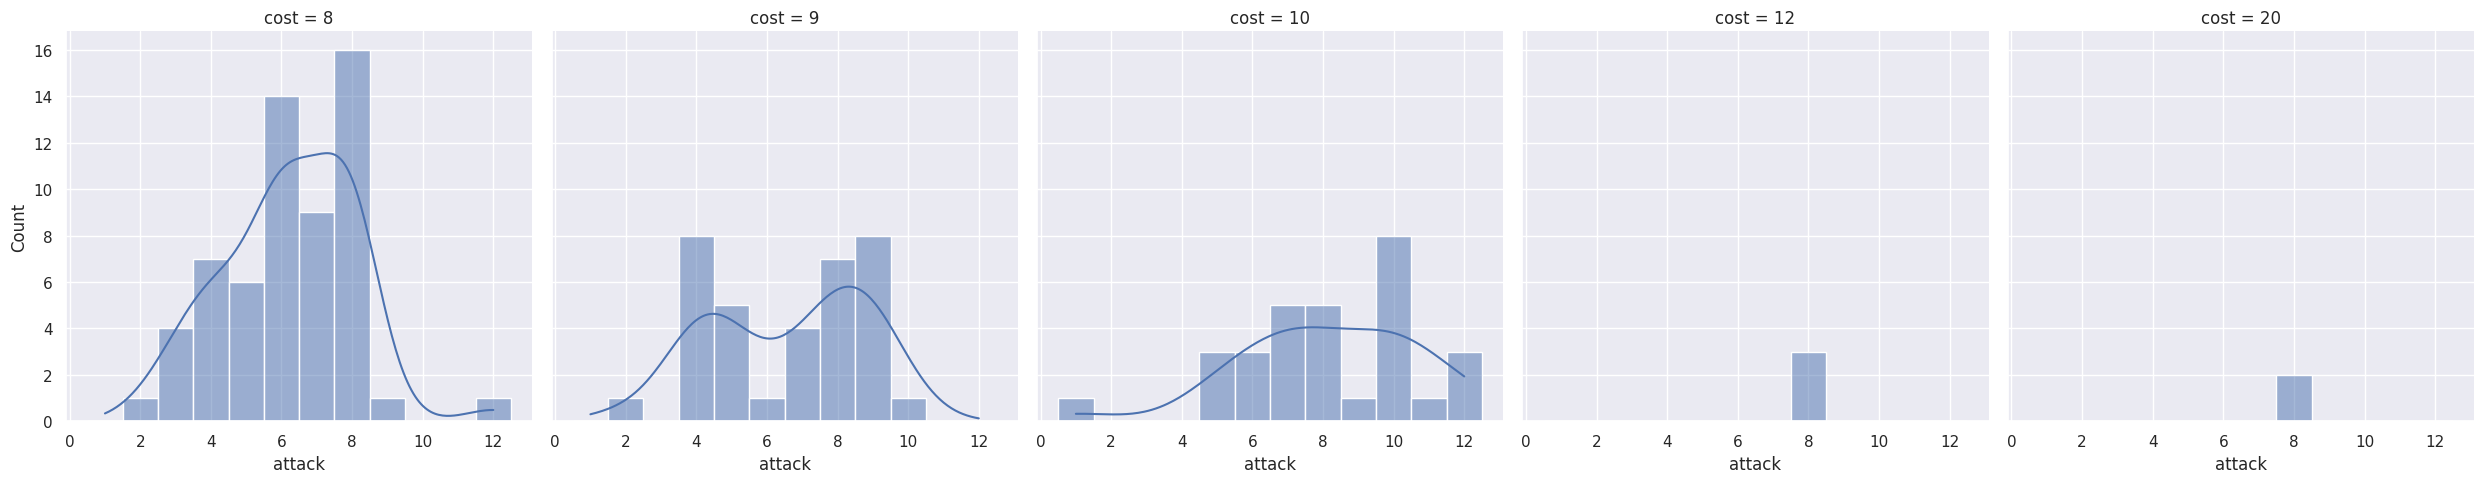

In [ ]:
# Python
for cost in [[0, 1, 2, 3], [4, 5, 6, 7], [8, 9, 10, 12, 20]]:
  sns.displot(
      data = Neutral_df[Neutral_df["cost"] >= cost[0]][Neutral_df["cost"] <= cost[-1]],
      # data = Neutral_df,
      x = 'attack',
      col = 'cost',
      kde = True,
      discrete=True
  );

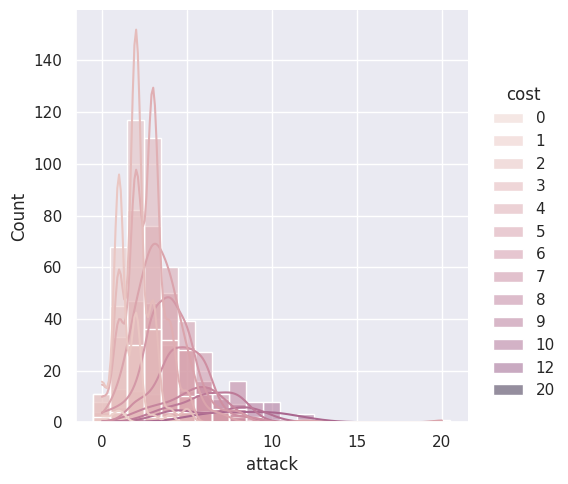

In [ ]:
# Python
sns.displot(
    data = Neutral_df,
    # data = Neutral_df[Neutral_df["cost"] <= 6],
    x = 'attack',
    hue = 'cost',
    kde = True,
    discrete=True
);

Из графиков видно:

1. Количество карт существ заметно уменьшается по мере роста ее стоимости и достигает пика при стоимости равной 3-м.


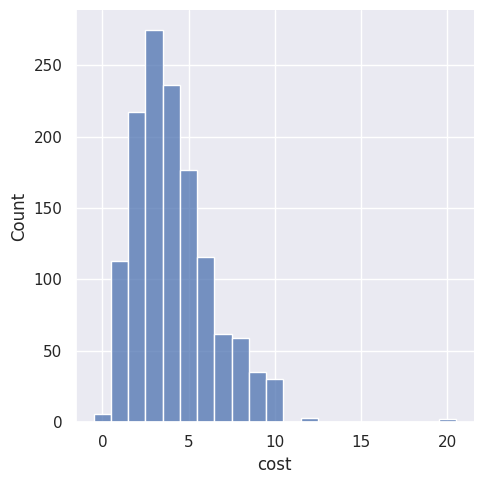

In [ ]:
# Python
sns.displot(
    x = 'cost',
    data = Neutral_df,
    discrete=True
);

2. Распределение сил, при увеличении стоимости, движется в право, то есть в среднем растет.

3. Также распределение "расплывается", т.е. при большей стоимости существует куда больше карт, которые, имеют слабые показатели атаки, но компенсируют это сильной способностью, например для сравнения:

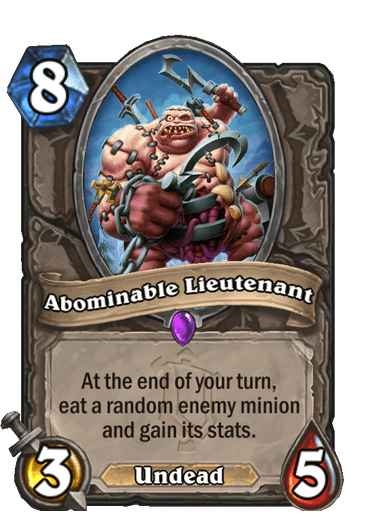

и

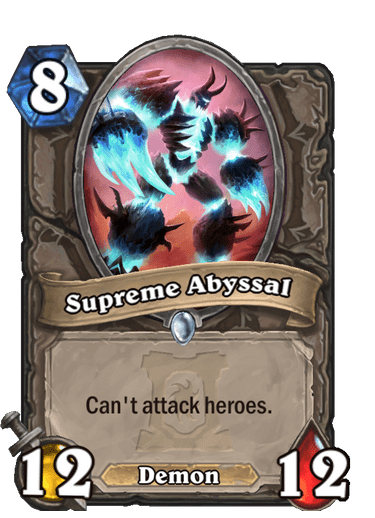

Первая карта полезна, благодаря своей способности, когда как вторая только своими показателями силы и здоровья

Давайте далее сравним два класса: паладина и мага

Паладин имеет много существ, с малой стоимостью, высокой атакой и низкой выживаемостью, является классом для любителей агрессивной игры со стола (используя крупных существ) и забафов их. Когда как маг играет много заклинаний и не может похвастаться сильными картами

Давайте рассмотрим существ со стоимостью в пределах 3-х, чтобы продемонстрировать это.

In [ ]:
%%R
Paladin_lc <- filter(Paladin_df, cost %in% c(0, 1, 2, 3))
# Paladin_lc
Mage_lc <- filter(Mage_df, cost %in% c(0, 1, 2, 3))
# Mage_lc

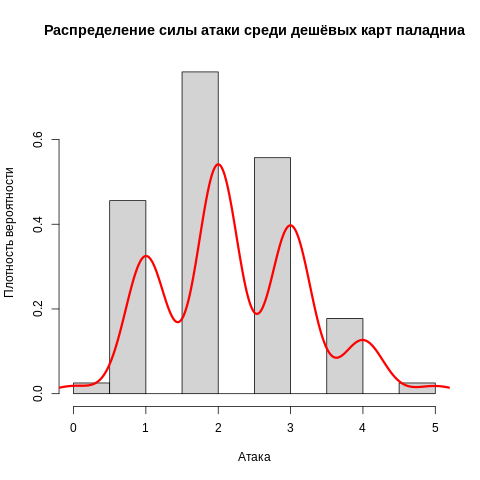

In [ ]:
%%R
hist(
    Paladin_lc$attack,
    # breaks = 30,
    freq = FALSE,
    xlab = "Атака",
    ylab = "Плотность вероятности",
    main = "Распределение силы атаки среди дешёвых карт паладниа",
    xlim = c(0, 5),
    # ylim = c(0, 1)
)
lines(density(Paladin_lc$attack), col = "red", lwd = 3)

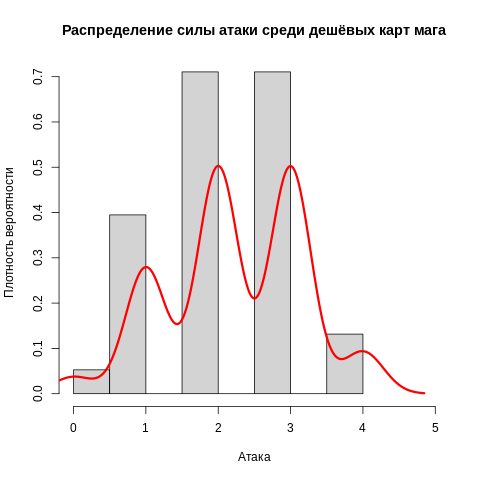

In [ ]:
%%R
hist(
    Mage_lc$attack,
    # breaks = 30,
    freq = FALSE,
    xlab = "Атака",
    ylab = "Плотность вероятности",
    main = "Распределение силы атаки среди дешёвых карт мага",
    xlim = c(0, 5),
    # ylim = c(0, 0.6)
)
lines(density(Mage_lc$attack), col = "red", lwd = 3)

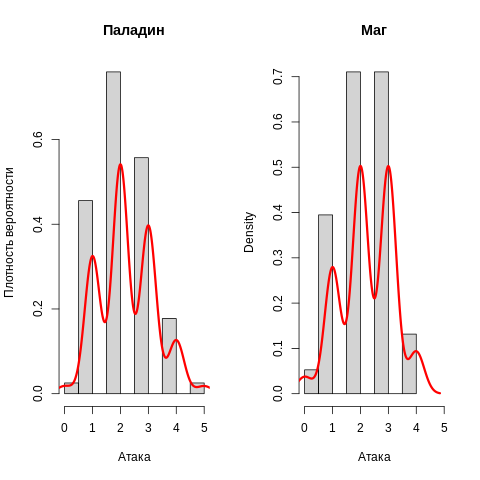

In [ ]:
%%R
layout(matrix(1:2, ncol = 2))

hist(
    Paladin_lc$attack,
    # breaks = 30,
    freq = FALSE,
    xlab = "Атака",
    ylab = "Плотность вероятности",
    main = "Паладин",
    xlim = c(0, 5),
    # ylim = c(0, 1)
)
lines(density(Paladin_lc$attack), col = "red", lwd = 3)
hist(
    Mage_lc$attack,
    # breaks = 30,
    freq = FALSE,
    xlab = "Атака",
    main = "Маг",
    xlim = c(0, 5),
    # ylim = c(0, 0.6)
)
lines(density(Mage_lc$attack), col = "red", lwd = 3)

Результаты расходятся с моими суждениями. Как оказалось, распределение сил атаки существ равны у двух классов.

Могу объяснить это тем, что агрессивная игра паладина тесно связана с его заклинаниями, способными выставить на стол большое количество мелких существ. Но, сказать честно, я ожидал доминацию паладина в смысле характеристик.

##Альтернатива

Давайте посмотрим на распределение покупательной способности посетителей и построим для них ядерные оценки:

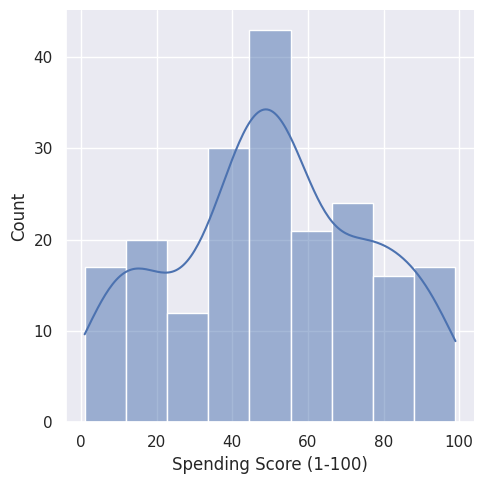

In [ ]:
# Python
sns.displot(
    data = df,
    x = 'Spending Score (1-100)',
    kde = True
)

Тогда, если рассмотреть разделение по полу:

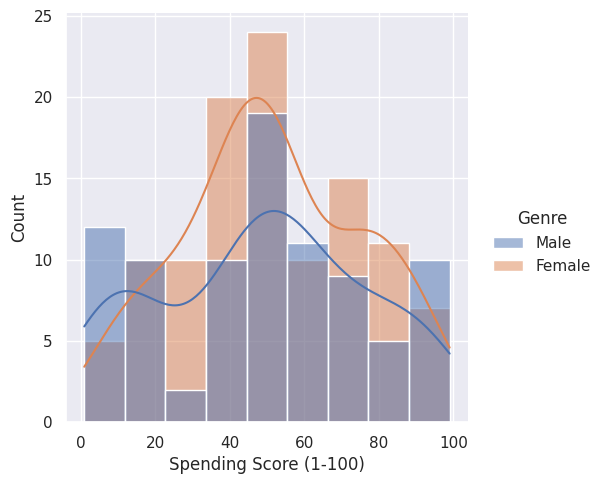

In [ ]:
# Python
sns.displot(
    x = 'Spending Score (1-100)',
    data = df,
    kde = True,
    hue = 'Genre'
)

Давайте рассмотрим теперь получаемый доход:

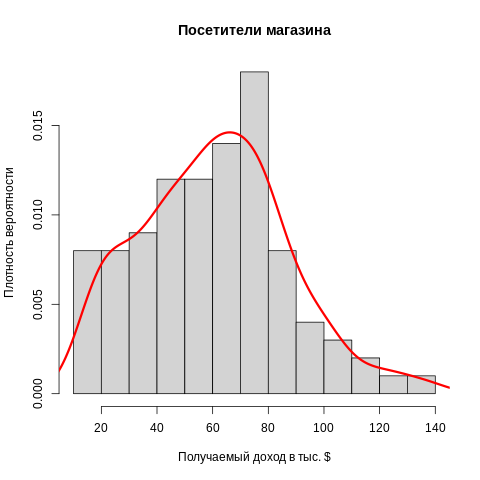

In [ ]:
%%R

hist(
    df$Annual.Income..k..,
    freq = FALSE,
    xlab = "Получаемый доход в тыс. $",
    ylab = "Плотность вероятности",
    main = "Посетители магазина",
)
lines(density(df$Annual.Income..k..), col = "red", lwd = 3)

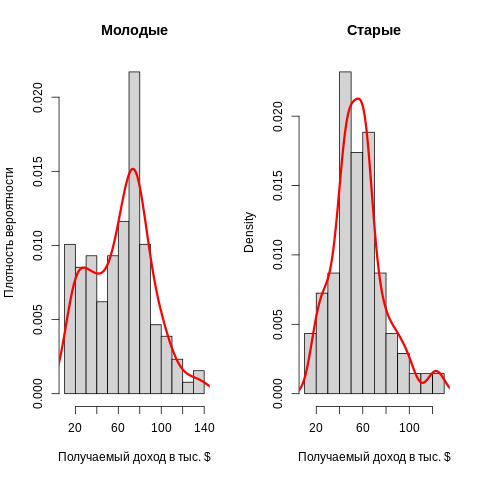

In [ ]:
%%R
layout(matrix(1:2, ncol = 2))
# Neutral_df[which(Neutral_df$cardSet == "March of the Lich King"), ]$attack
hist(
    df[which(df$Age < 44), ]$Annual.Income..k..,
    freq = FALSE,
    xlab = "Получаемый доход в тыс. $",
    ylab = "Плотность вероятности",
    main = "Молодые",
)
lines(density(df[which(df$Age <= 44), ]$Annual.Income..k..), col = "red", lwd = 3)
hist(
    df[which(df$Age > 44), ]$Annual.Income..k..,
    freq = FALSE,
    xlab = "Получаемый доход в тыс. $",
    # ylab = "Плотность вероятности",
    main = "Старые",
)
lines(density(df[which(df$Age > 44), ]$Annual.Income..k..), col = "red", lwd = 3)

## №2. Анализ данных с помощью cdplot, dotchart, boxplot, stripchart.

### cdplot:

Давайте рассмотрим теперь как карты зависят от своей редкости

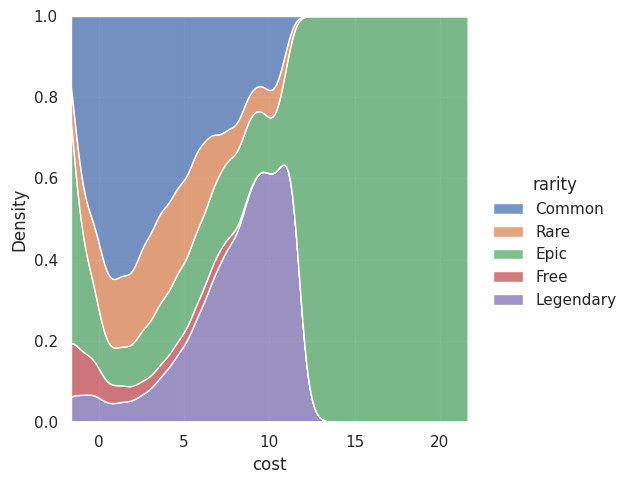

In [ ]:
# Python
sns.displot(data = Neutral_df, hue = "rarity", multiple = "fill", x = "cost", kind = "kde");

Для начала объясню этот обрыв с эпическими картами: всего в игре есть несколько эпических гигантов (и пара классовых карт с похожим эффектом), только их стоимость превышает предельную (10). Их возможно сыграть только при выполнении каких-либо условий, например:

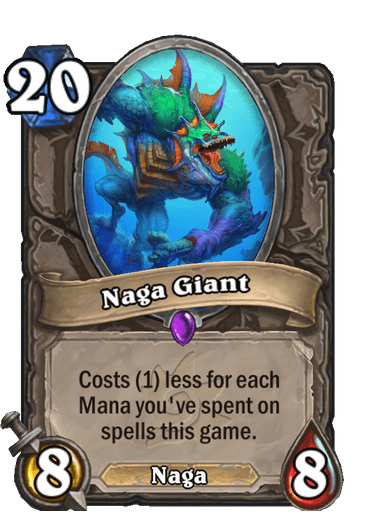

В остальном наблюдается тенденция: легендарные карты дорогие, среди дегевых обычных большинство. И бесплатных (дающихся бесплатно при заходе в игру) нет дороже 7 маны

Давайте рассмотрим аналогично зависимость здоровья карт паладина от его редкости

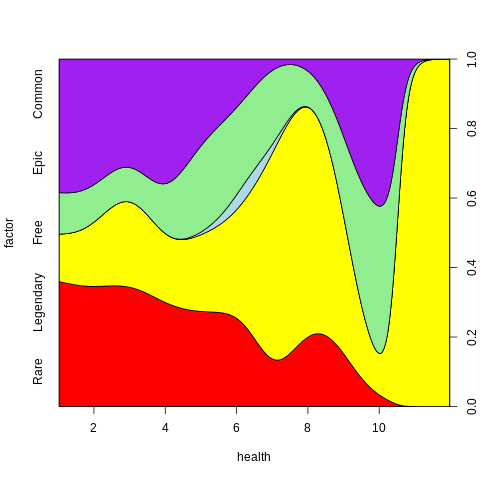

In [ ]:
%%R
Paladin_df$factor <- factor(Paladin_df$rarity)
cdplot(factor ~ health, col = c("red", "yellow", "lightblue", "lightgreen", "purple", "blue"), data = Paladin_df)

Опять видим обрыв после 10 здоровья:

Карты с большой стоимостью особо сильны, а легендарных карт у паладина с большой стоимостью достаточно много. Так что не удивительно, что их, среди карт с большим здоровьем, большинство



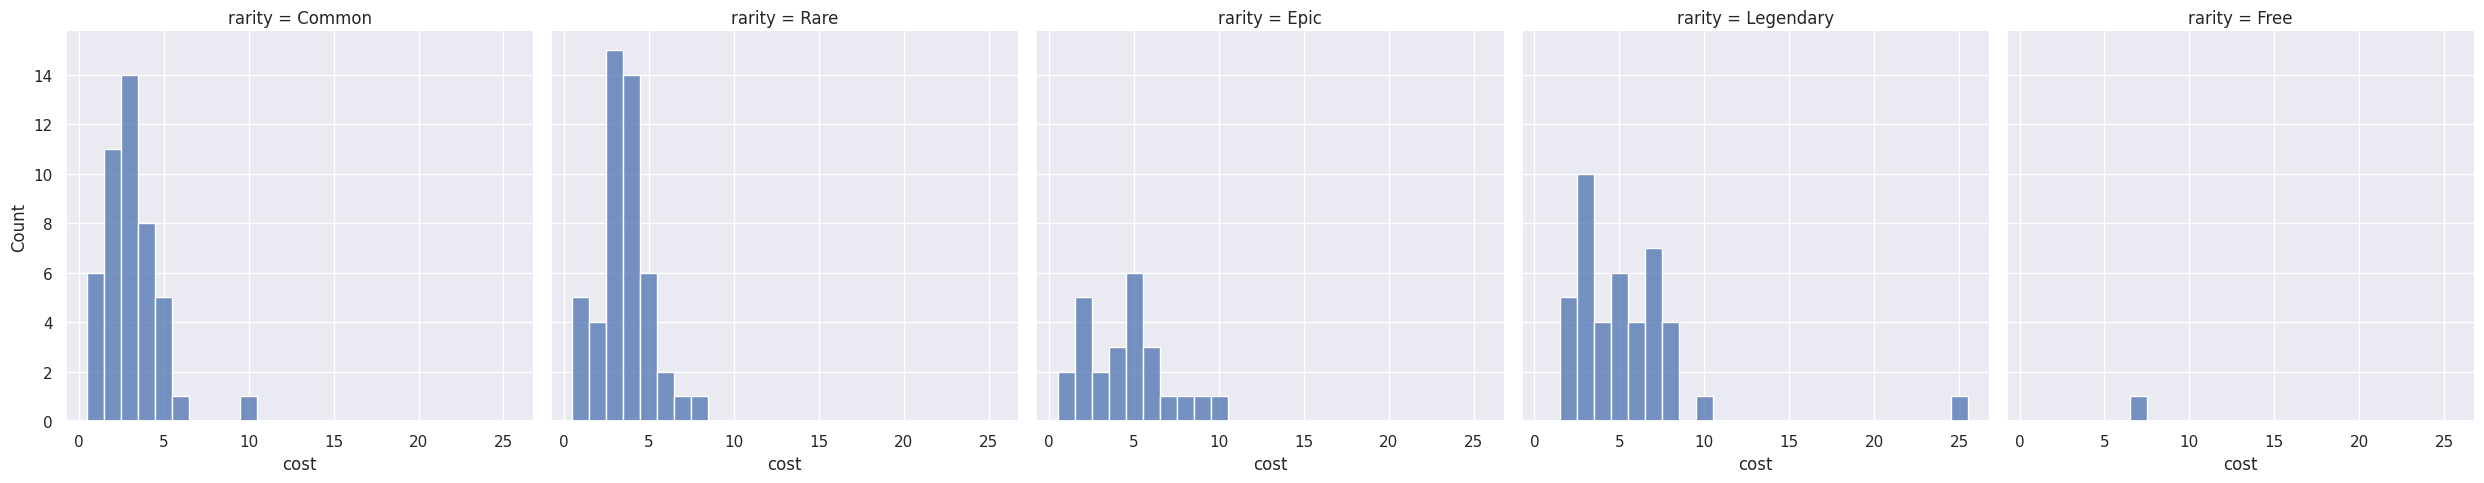

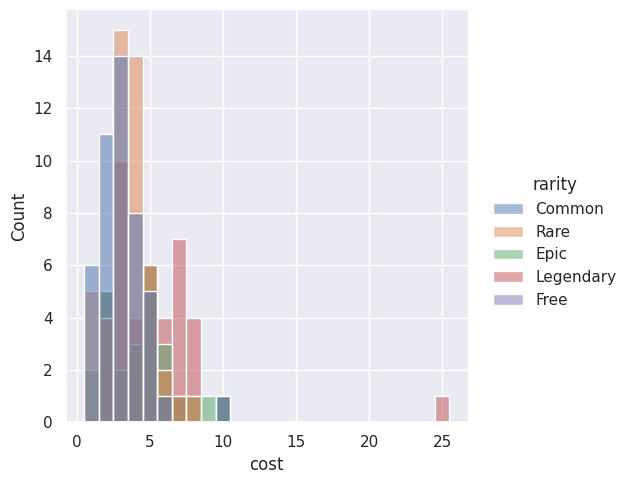

In [ ]:
# Python
sns.displot(
    data = Paladin_df,
    x = 'cost',
    col = 'rarity',
    # kde = True,
    discrete=True
);

sns.displot(
    data = Paladin_df,
    x = 'cost',
    hue = 'rarity',
    # kde = True,
    discrete=True
);

В остальных случаях эти две зависимости ничего особого не говорят

### dotchart:

**Точечный график** как представление распределения состоит из группы точек данных, нанесенных на простой масштаб. Точечные диаграммы используются для непрерывных , количественных , одномерных данных. Точечные графики - это один из простейших статистических графиков, который подходит для небольших и средних наборов данных. Они полезны для выделения кластеров и пробелов, а также выбросов . Другое их преимущество - сохранение числовой информации. При работе с большими наборами данных (около 20–30 или более точек данных) связанный стержневой график , прямоугольная диаграмма или гистограмма могут быть более эффективными, так как точечные графики после этого момента могут стать слишком загроможденными. Точечные графики можно отличить от гистограмм тем, что точки не расположены равномерно по горизонтальной оси.

Хотя сюжет кажется простым, его расчет и лежащая в его основе статистическая теория непросты. Алгоритм вычисления точечной диаграммы тесно связан с оценкой плотности ядра . Выбранный размер точек влияет на внешний вид сюжета. Выбор размера точки эквивалентен выбору полосы пропускания для оценки плотности ядра.

В R это реализуется с помощью функции dotchart(), в Python аналогичный график строится при помощи функции scatter().

Итак, нам нужно небольшое количество данных. Рассмотрим уже рассмотренную нами ранее таблицу паладина с существами со стоимостью меньшей 4.

In [ ]:
# Python
import plotly.express as px
Paladin_lc = Paladin_df[Paladin_df["cost"] < 4]
fig = px.scatter(
    Paladin_lc,
    x = "name",
    y = "cost",
    color = "rarity"
)
fig.show()

fig = px.scatter(
    Mage_df[Mage_df["cost"] < 4],
    x = "name",
    y = "cost",
    color = "rarity"
)
fig.show()

Здесь мы можем опять сравнить два класса:

У мага легендарных (особых) карт не настолько много, как у паладина. что так же может сказываться на их игру. Но, судя по нынешней мете, из дешевых легендарных карт, в основном, играются только карты заклинаний, так что судить об игре класса на основании числа дешевых легендарных существ не предполагается возможным

### boxtplot:

Давайте рассмотрим зависимость здоровья от атаки. Этот показатель достаточно уникальный и в игре достаточно много карт с уже знакомыми статистиками (вроде 2 атаки и 3 здоровья), которые уже устоялись. Поэтому характеристики, в которых например атака много выше здоровья - крайняя редкость (иначе такие карты были бы неиграбельны или имели какую-то особую способность вроде "рывка", чтобы сохранялся баланс и карта могла окупать свою стоимость). Но в то же время уже сущесвтуют существа с большим уровнем здоровья и малым уровнем атаки, например:

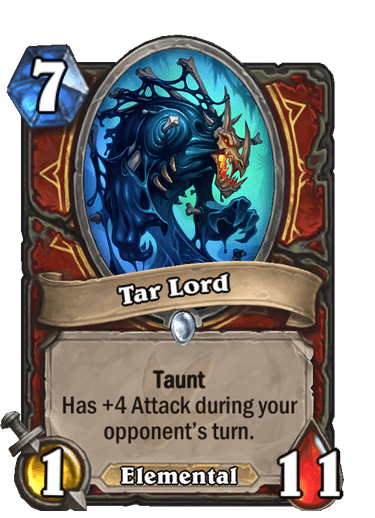


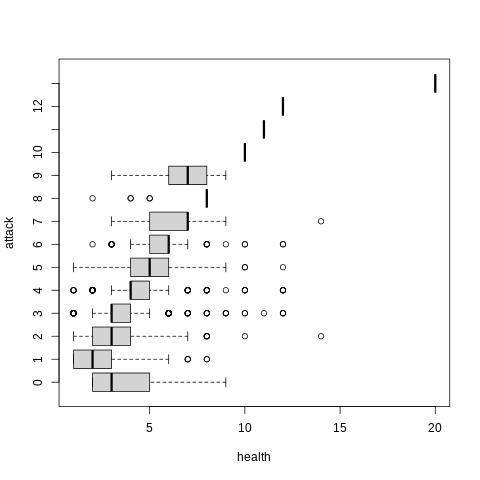

In [ ]:
%%R
boxplot(
    health ~ attack,
    data = Neutral_df,
    horizontal=TRUE
)

В самом деле, устоявшиеся нормы атаки являются абсолютным большинством (например 1/2 или 4/4), но существуют и много выбросов у атак от 1 до 6. Это связано с тем, что такие карты легко вписываются в концепцию "долгой" игры, при которой ни та, ни другая сторона не могут нанести много ущерба противнику.

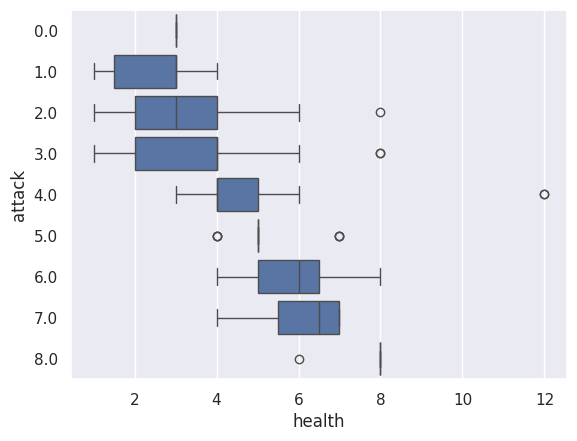

In [ ]:
# Python
sns.boxplot(
    data = Mage_df,
    x = "health",
    y = "attack",
    orient = "h"
);

Для мага почти все карты сбалансированы и у него отсутствуют большие карты

---



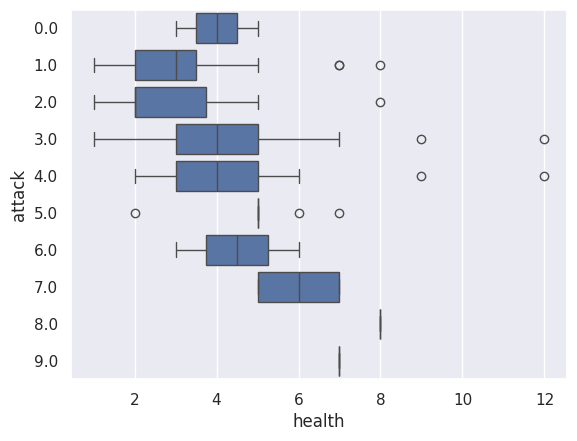

In [ ]:
# Python
sns.boxplot(
    data = Paladin_df,
    x = "health",
    y = "attack",
    orient = "h"
);

У паладина так же карты сбалансированы, но присутствует множество уникальных карт-выбросов.

### stripchart:

Рассмотрим число драконов, которое выпустила компания за каждое дополнение

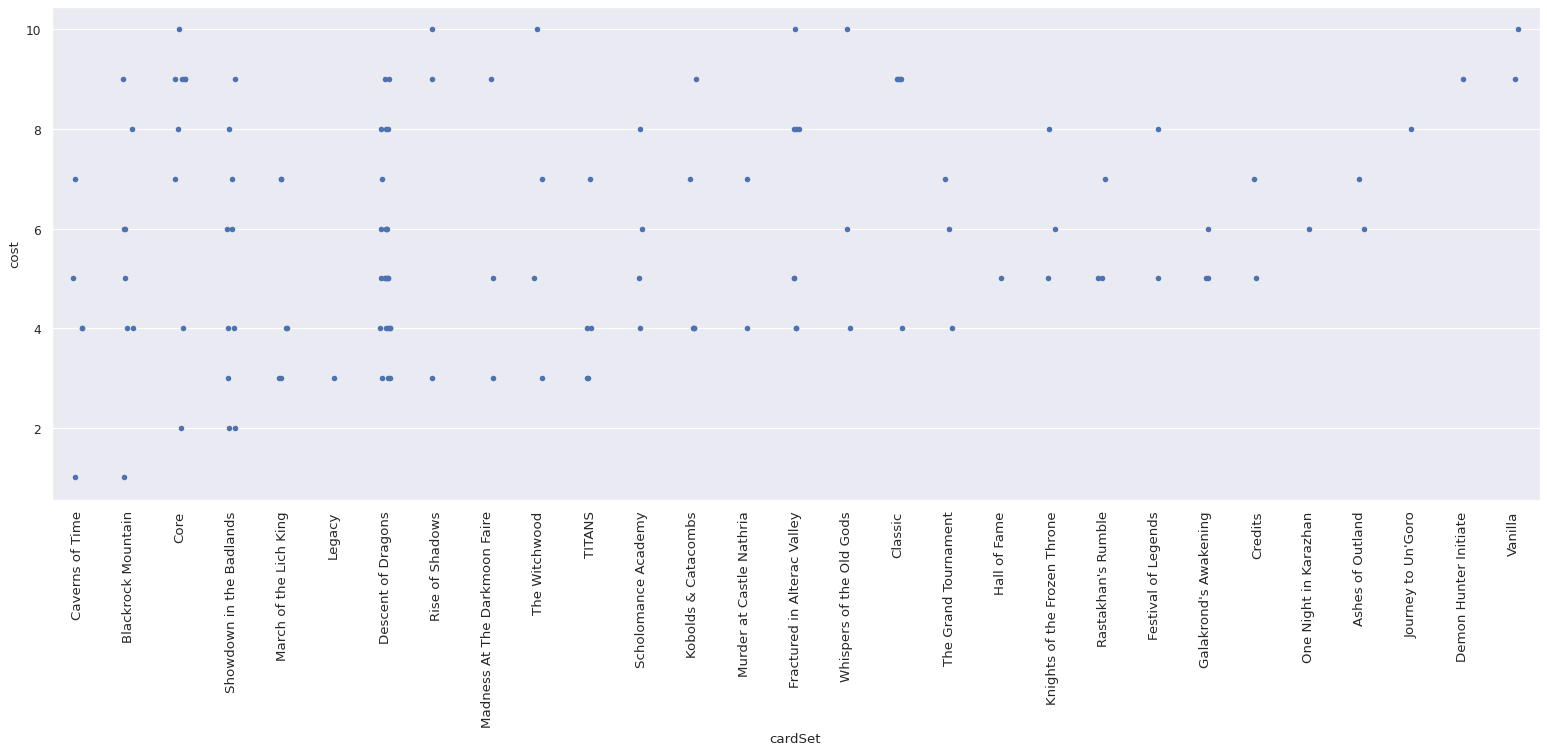

In [ ]:
# Python


fig, ax = plt.subplots(figsize=(24, 8), dpi=80)
sns.stripplot(Dragon_df, x = 'cardSet', y = "cost")
plt.tick_params(axis='x', which='major', labelsize=12, rotation=90)

plt.show()

Из графика видно, что нааибольшее пополнение набора драконами было во время "Натиска драконов".

## №3. Анализ выбросов с помощью критериев Граббса и Диксона.

**Тесты Граббса и Диксона** используется для определения наличия выбросов в наборе данных.

Давайте смотреть выбросы здоровья (т.к. выбросов атаки почти не будет, т.к. игра подразумевает, что большого числа атки быть не должно, ведь это сильно бьет по балансу игры)

### Тест Граббса

Критерий Граббса имеет статистику $G=\frac{max_{i=1,…,N}|Y_{i}−\overline{Y}|}{s}$, где s
 - выборочное стандартное отклонение, $\overline{Y}$
 - выборочное среднее.

Будем рассматривать для критерия Габбса для выборки общих карт. Выбросы будем смотреть исходя из здоровья карт.

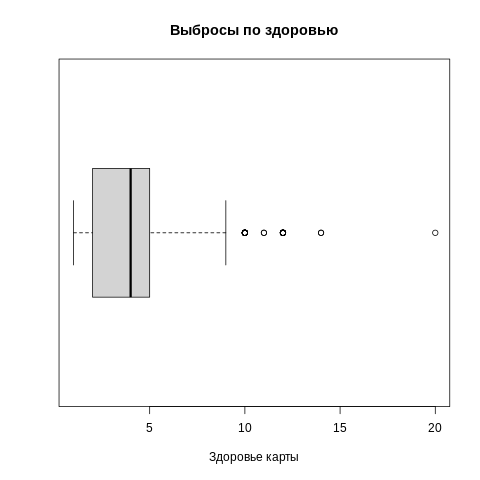

In [ ]:
%%R
boxplot(Neutral_df$health, horizontal = TRUE, xlab="Здоровье карты", main = "Выбросы по здоровью")

In [ ]:
!pip install outlier_utils

In [ ]:
# Python
from outliers import smirnov_grubbs as grubbs

In [ ]:
# Python
print(grubbs.max_test_outliers(Neutral_df.health.to_numpy(), alpha=0.05))

[20.0, 14.0, 14.0]


Односторонний тест Граббса нашел 3 выброса:

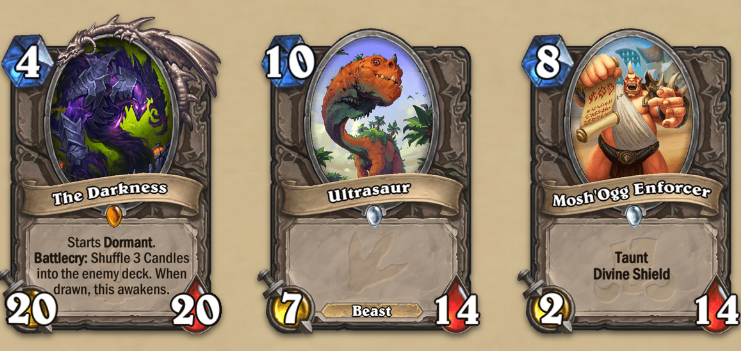

Теперь проведём тест Граббса с помощью языка R на укороченном датасете карт паладина дополнения "натиск драконов" и по стоимости:

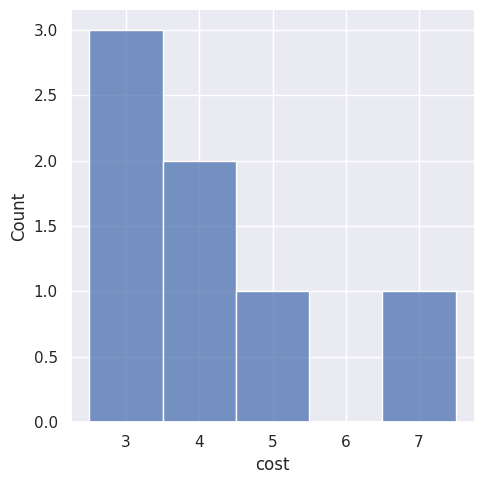

In [ ]:
# Python

sns.displot(
    data = Paladin_df[Paladin_df["cardSet"] == "Descent of Dragons"],
    x = 'cost',
    discrete=True
);

In [ ]:
%%R
grubbs.test(Paladin_df[which(Paladin_df$cardSet == "Descent of Dragons"), ]$cost)


	Grubbs test for one outlier

data:  Paladin_df[which(Paladin_df$cardSet == "Descent of Dragons"),     ]$cost
G = 1.95180, U = 0.25926, p-value = 0.04513
alternative hypothesis: highest value 7 is an outlier



Тест Граббса сообщает, что мы не можем принять гипотезу, что карта со стоимостью 7 является выбросом, т.к. p-value < 0.05

Давайте рассмотрим базу, в которой отчетливо виден выброс, за основу возьмем  нейтральные карты дополнения "Voyage to the Sunken City", без обычных карт

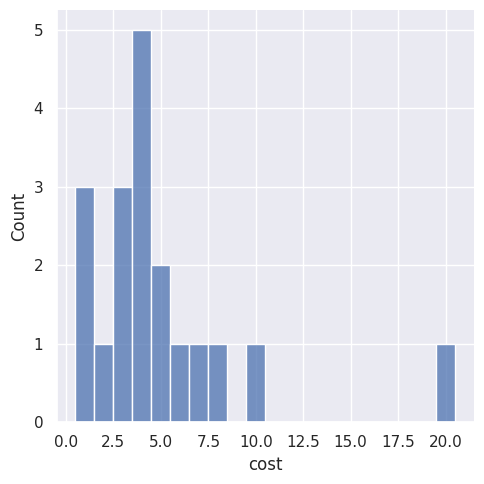

In [ ]:
# Python

sns.displot(
    data = Neutral_df[Neutral_df["cardSet"] == "Voyage to the Sunken City"][Neutral_df["rarity"] != "Common"],
    x = 'cost',
    discrete=True
);

In [ ]:
%%R
data <- Neutral_df[which(Neutral_df$cardSet == "Voyage to the Sunken City"), ]
grubbs.test(data[which(data$rarity != "Common"), ]$cost)


	Grubbs test for one outlier

data:  data[which(data$rarity != "Common"), ]$cost
G = 3.46154, U = 0.29734, p-value = 7.048e-05
alternative hypothesis: highest value 20 is an outlier



Тест Граббса сообщает, что мы не можем принять гипотезу, что карта со стоимостью 20 является выбросом, т.к. p-value < 0.05.

Давайте теперь посмотрим что скажет тест Диксона на этот же набор карт

### Тест Диксона

In [ ]:
%%R
data <- Neutral_df[which(Neutral_df$cardSet == "Voyage to the Sunken City"), ]
dixon.test(data[which(data$rarity != "Common"), ]$cost)


	Dixon test for outliers

data:  data[which(data$rarity != "Common"), ]$cost
Q = 0.63158, p-value < 2.2e-16
alternative hypothesis: highest value 20 is an outlier



Как видим, явные выбросы два метода выявили удачно

In [ ]:
%%R
dixon.test(Paladin_df[which(Paladin_df$cardSet == "Descent of Dragons"), ]$cost)


	Dixon test for outliers

data:  Paladin_df[which(Paladin_df$cardSet == "Descent of Dragons"),     ]$cost
Q = 0.5, p-value = 0.1075
alternative hypothesis: highest value 7 is an outlier



Получили, что тест Диксона не принимает гипотезу, что карта со стоимостью 7 является выбросом, а тест Граббса не отрицает.

Так что ответ будет зависеть от намерений заказчика (шутка)

## №4. Инструменты для заполнения пропусков в данных. Сравнение результатов заполнения с истинными значениями.

В этой части будем заполнять пропуски в наборе данных атаки обычных карт паладина

In [ ]:
%%R
Paladin_common <- Paladin_df[which(Paladin_df$rarity == "Common"), ]

In [ ]:
# Python
Paladin_common = Paladin_df[Paladin_df["rarity"] == "Common"].copy()

Их всего:

In [ ]:
# Python
Paladin_common.shape[0]

46

Распределение атаки:

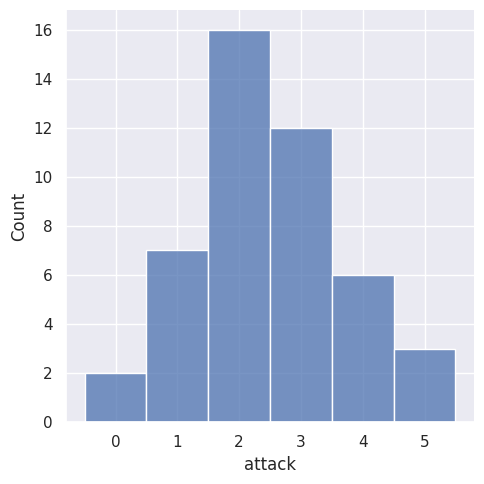

In [ ]:
# Python
sns.displot(
    data = Paladin_common,
    x = 'attack',
    discrete=True
);

Сделаем пропуски вручную. Сгенерируем случайный набор индексов:

In [ ]:
# Python
rd_arr = np.random.randint(Paladin_common.shape[0], size = 5)
rd_arr

array([13, 43, 24, 25, 18])

In [ ]:
# Python
NA_index = [13, 43, 24, 25, 18]

Paladin_tmp = Paladin_common.copy()
Paladin_tmp.iloc[NA_index, 8] = np.nan
Paladin_tmp.iloc[NA_index]

,cardId,dbfId,name,cardSet,type,rarity,health,cost,attack
171,ULD_439,54038,Sandwasp Queen,Saviors of Uldum,Minion,Common,1.0,2.0,NaN
354,BOT_537,49169,Mechano-Egg,The Boomsday Project,Minion,Common,5.0,5.0,NaN
224,NX2_021,86655,Knight of the Dead,March of the Lich King,Minion,Common,5.0,3.0,NaN
228,REV_947,78080,Muckborn Servant,Murder at Castle Nathria,Minion,Common,4.0,3.0,NaN
190,LOOT_398,46258,Benevolent Djinn,Kobolds & Catacombs,Minion,Common,4.0,3.0,NaN


In [ ]:
%%R
NA_index <- c(13, 43, 24, 25, 18)
Paladin_tmp <- Paladin_common
Paladin_tmp[NA_index, ]$attack <- NA
Paladin_tmp[NA_index, ]

      X  cardId  dbfId                 name                       cardSet
32  167 DMF_194  61305 Redscale Dragontamer Madness At The Darkmoon Faire
123 349  WW_342 100230       Lawful Longarm      Showdown in the Badlands
55  222 WON_311 103214    Keeper of Uldaman               Caverns of Time
56  224 NX2_021  86655   Knight of the Dead        March of the Lich King
40  188  SW_315  64368   Alliance Bannerman           United in Stormwind
      type rarity health cost attack factor
32  Minion Common      3    2     NA Common
123 Minion Common      5    5     NA Common
55  Minion Common      4    3     NA Common
56  Minion Common      5    3     NA Common
40  Minion Common      2    3     NA Common


In [ ]:
# Python
Paladin_tmp.ffill(inplace=True)
print("Заполненные данные:\n", Paladin_tmp.iloc[NA_index].attack)

Заполненные данные:
 171    2.0
354    1.0
224    3.0
228    3.0
190    2.0
Name: attack, dtype: float64


In [ ]:
# Python
print("Оригинальные:\n", Paladin_common.iloc[NA_index].attack)

Оригинальные:
 171    3.0
354    0.0
224    5.0
228    2.0
190    2.0
Name: attack, dtype: float64


In [ ]:
%%R
Paladin_tmp_filled_1 <- mice(Paladin_tmp)
Paladin_tmp_filled <- complete(Paladin_tmp_filled_1, action = 3)


 iter imp variable
  1   1  attack
  1   2  attack
  1   3  attack
  1   4  attack
  1   5  attack
  2   1  attack
  2   2  attack
  2   3  attack
  2   4  attack
  2   5  attack
  3   1  attack
  3   2  attack
  3   3  attack
  3   4  attack
  3   5  attack
  4   1  attack
  4   2  attack
  4   3  attack
  4   4  attack
  4   5  attack
  5   1  attack
  5   2  attack
  5   3  attack
  5   4  attack
  5   5  attack
[1] 2 4 1 3 2


Заполненные данные:

In [ ]:
%%R
print(Paladin_tmp_filled[NA_index, ]$attack)

[1] 2 4 1 3 2


Оригинальные:

In [ ]:
%%R
print(Paladin_common[NA_index, ]$attack)

[1] 2 1 3 5 2


In [ ]:
# Python
print("Норма ошибки:", np.sqrt(np.mean((Paladin_tmp.iloc[NA_index].attack - Paladin_common.iloc[NA_index].attack)**2)))

Норма ошибки: 1.1832159566199232


Получили не очень большое отклонение.

Поэтому делаем вывод, что и в общей выборке при малом числе пропусков отклонение будет пренебрижительно малым.

## №5. Сгенерировать данные из нормального распределения с различными параметрами и провести анализ с помощью:
### графиков эмпирических функций распределений
### квантилей
### метода огибающих
### а также стандартных процедур проверки гипотез о нормальности (критерии Колмогорова-Смирнова,Шапиро-Уилка,Андерсона-Дарлинга,Крамера фон Мизеса, Колмогорова-Смирнова в модификации Лиллиефорса и Шапиро-Франсия).я).

In [ ]:
# Python
data1 = np.random.normal(0, 1, size = 10)
data2 = np.random.normal(0, 9, size = 50)
data3 = np.random.normal(1, 1, size = 100)
data4 = np.random.normal(3, 4, size = 1000)
data5 = np.random.normal(5, 3, size = 5000)

In [ ]:
%%R
data1 <- rnorm(10, 0, 1)
data2 <- rnorm(50, 0, 9)
data3 <- rnorm(100, 1, 1)
data4 <- rnorm(1000, 3, 4)
data5 <- rnorm(5000, 5, 3)

library(ggplot2)

norm_vec = data.frame(Factor = rep(c(50, 50,5000, 5000, 1000)),
                                   Variable = c(data1, data2, data3, data4, data5))
ggplot(norm_vec, aes(Variable, group = Factor, fill = Factor)) +
  geom_density(alpha = 0.3)

graph_distr <- function(x, pc, main_name = "")
{
  plot(x,pc, type = "l", col = rgb(0.5, 0.2, 0.7, 0.5), lwd = 2)
  plot(ecdf(x), add = TRUE)
}

### Эмпирическая функция распределения:

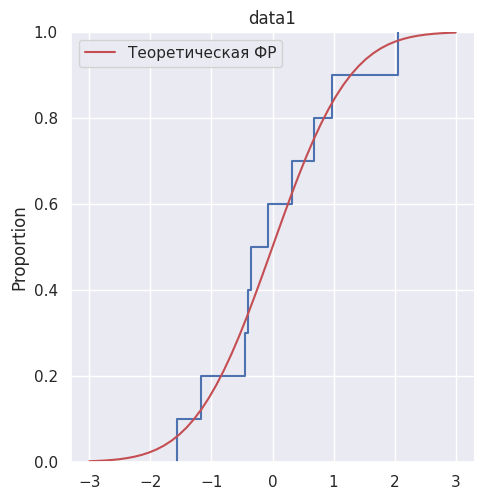

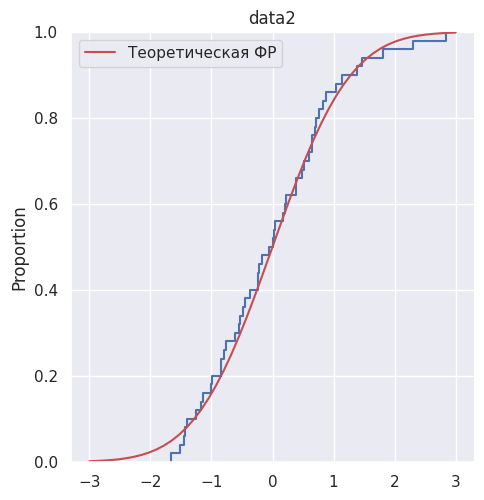

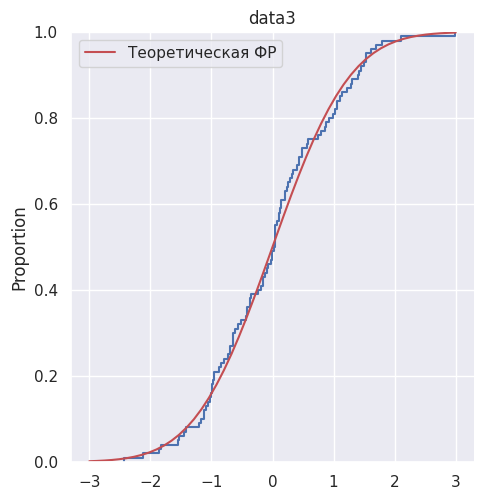

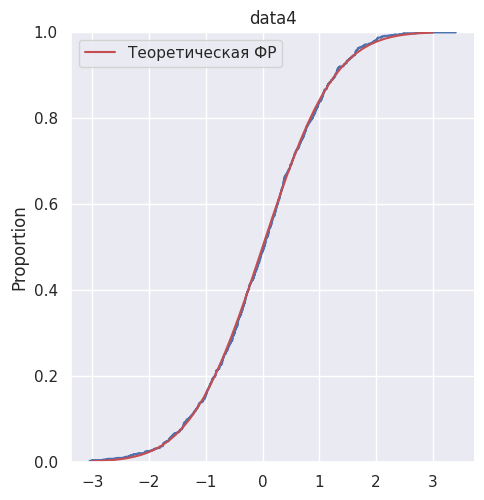

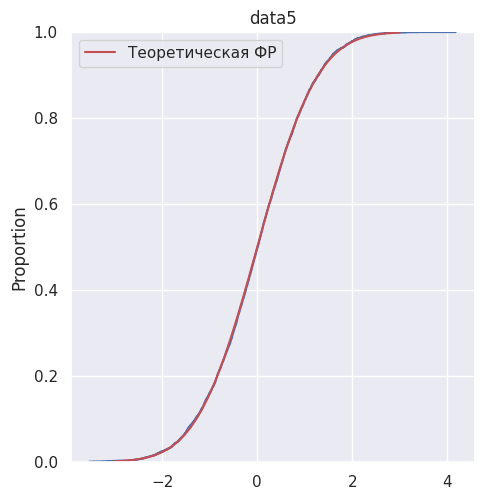

In [ ]:
# Python
for d,i in zip([data1, data2, data3, data4, data5], range(1, 6)):
  d = (d - np.mean(d)) / np.std(d)
  sns.displot(data = d, kind = "ecdf").set(title='data' + str(i));
  plt.gca().plot(np.linspace(-3, 3, num=50), norm.cdf(np.linspace(-3, 3, num=50)), color='r', label="Теоретическая ФР")
  plt.gca().legend()
  plt.show()

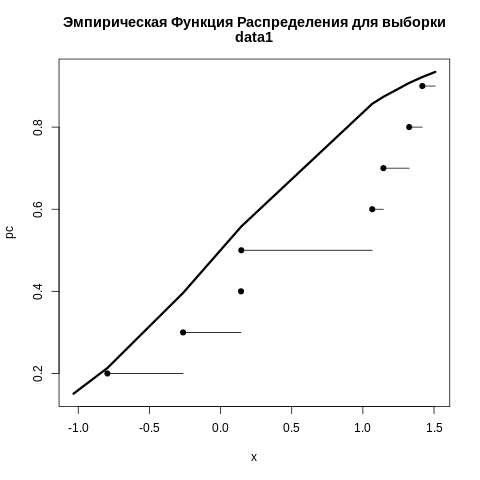

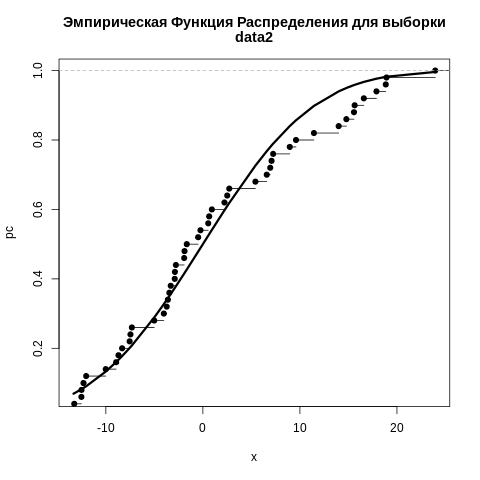

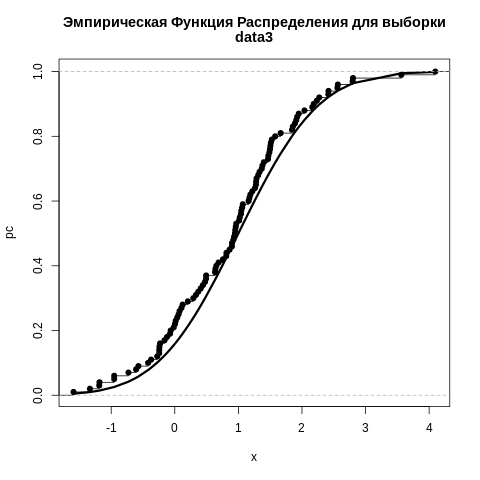

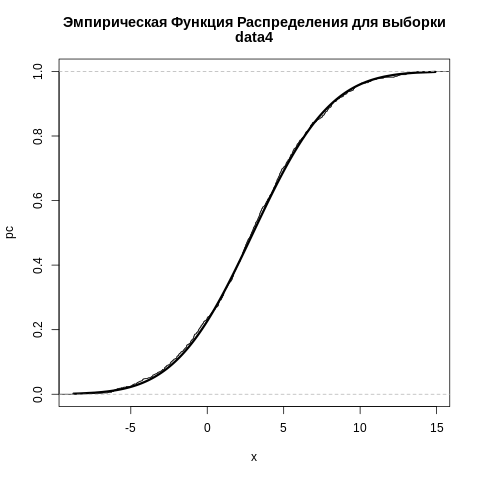

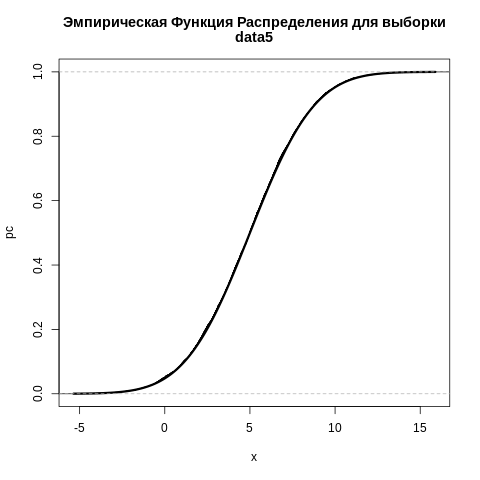

In [ ]:
%%R
#Выборки малого объема (не более 100)
data1 <- rnorm(10, 0, 1)
data2 <- rnorm(50, 0, 9)

#Выборки умеренного объема
data3 <- rnorm(100, 1, 1)
data4 <- rnorm(1000, 3, 4)
data5 <- rnorm(5000, 5, 3)


graph_distr <- function(x, pc, main_name = "")
{
  mn <- paste(c("Эмпирическая Функция Распределения для выборки", main_name))
  plot(x,pc, type = "l", lwd = 3, main = mn)
  plot(ecdf(x), add = TRUE)
}

data1 = sort(data1)
graph_distr(data1, pnorm(data1, mean = 0, sd = 1), "data1")

data2 = sort(data2)
graph_distr(data2, pnorm(data2, mean = 0, sd = 9), "data2")

data3 = sort(data3)
graph_distr(data3, pnorm(data3, mean = 1, sd = 1), "data3")

data4 = sort(data4)
graph_distr(data4, pnorm(data4, mean = 3, sd = 4), "data4")

data5 = sort(data5)
graph_distr(data5, pnorm(data5, mean = 5, sd = 3), "data5")

### квантили:

<Figure size 640x480 with 0 Axes>

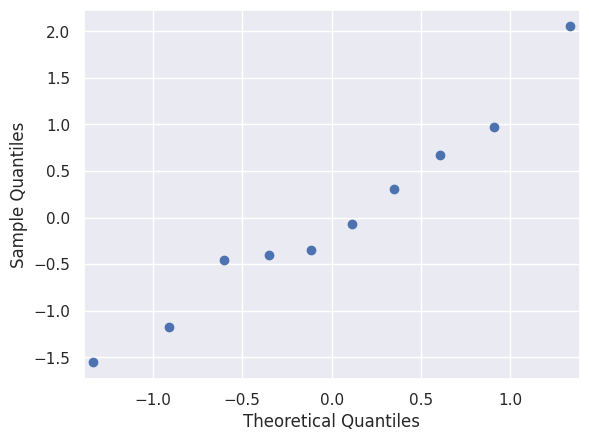

<Figure size 640x480 with 0 Axes>

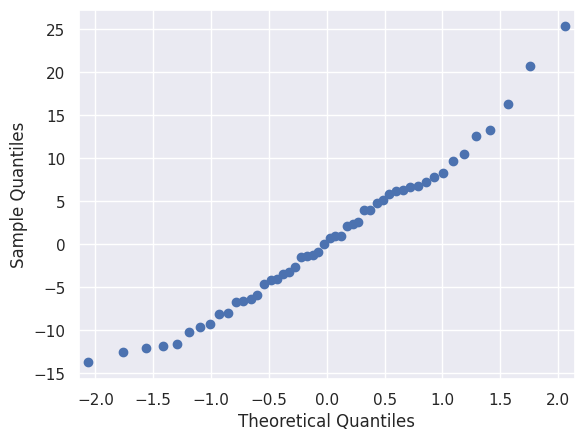

<Figure size 640x480 with 0 Axes>

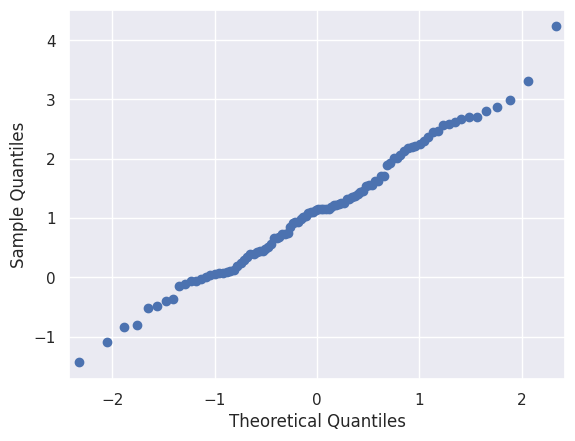

<Figure size 640x480 with 0 Axes>

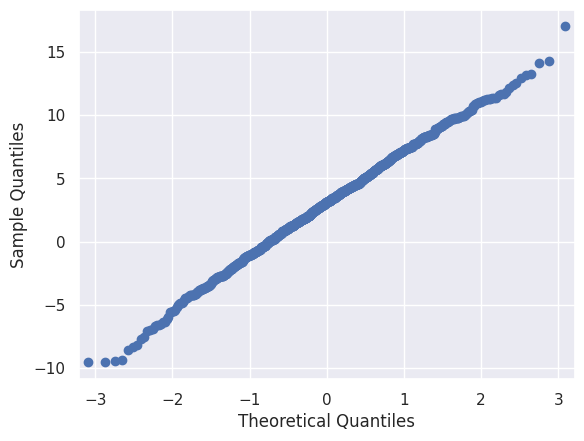

<Figure size 640x480 with 0 Axes>

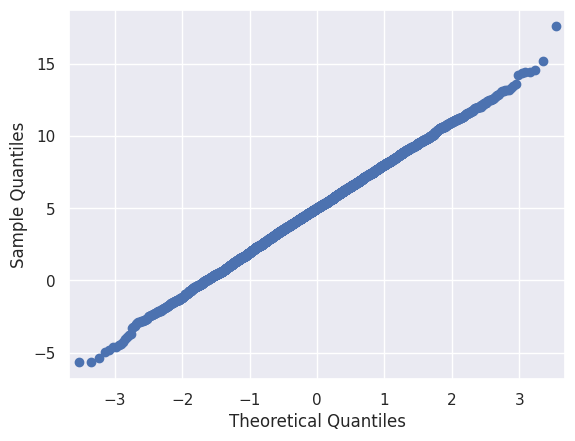

In [ ]:
# Python
import statsmodels.api as sm

for d in [data1, data2, data3, data4, data5]:
  plt.clf()
  sm.qqplot(d)
  plt.show()


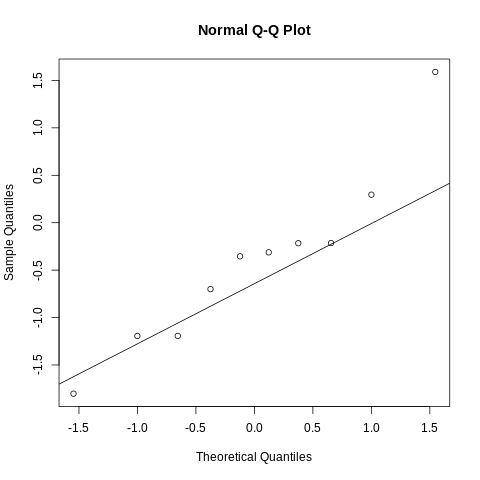

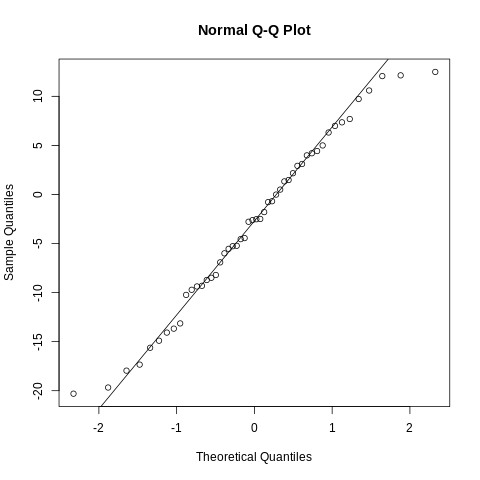

In [ ]:
%%R
qqgraph <- function(x){
  qqnorm(x)
  qqline(x)
}

qqgraph(data1)
qqgraph(data2)

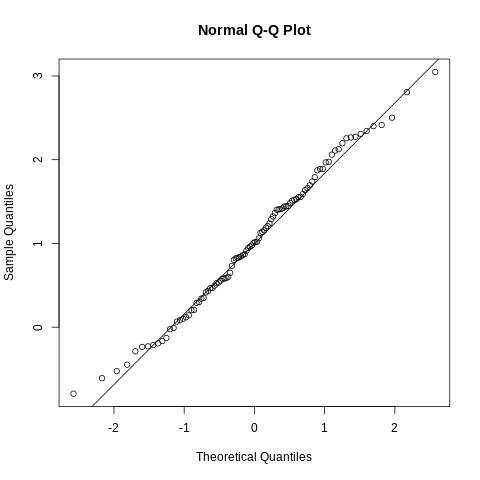

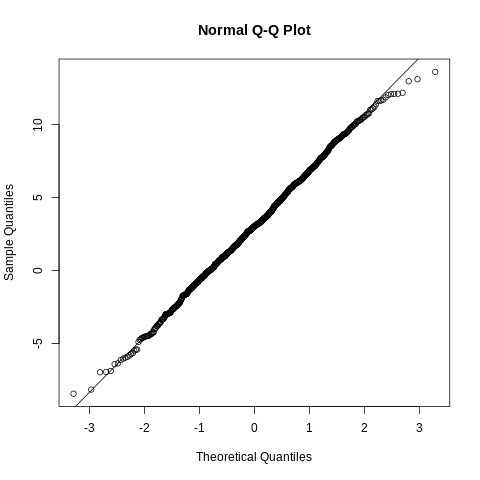

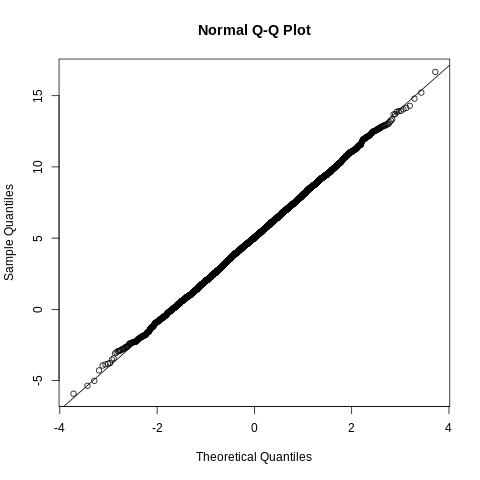

In [ ]:
%%R
qqgraph(data3)
qqgraph(data4)
qqgraph(data5)

На R, как и на python-е метод квантилей хорошо приблежает, но тем не менее точность уходшается по приблидении к краям. С увеличением выборки точность улучшается

### метод огибающих:

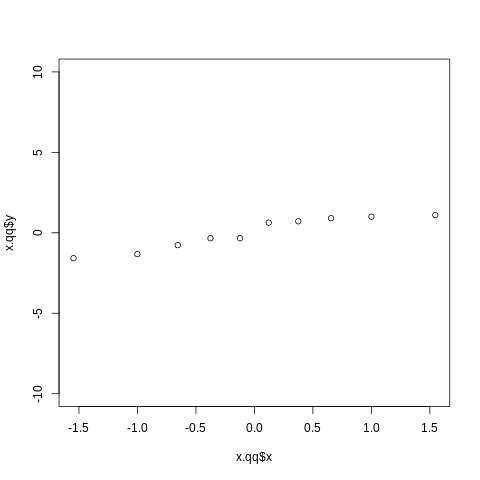

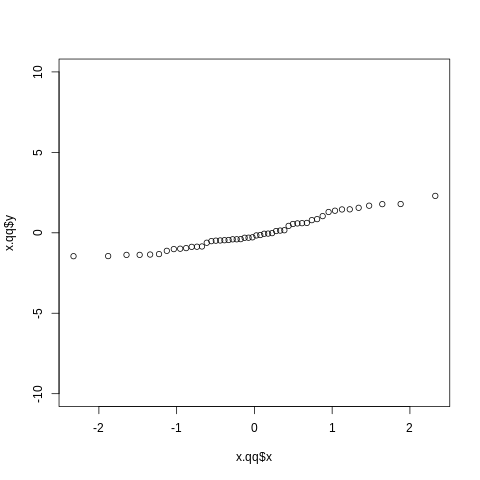

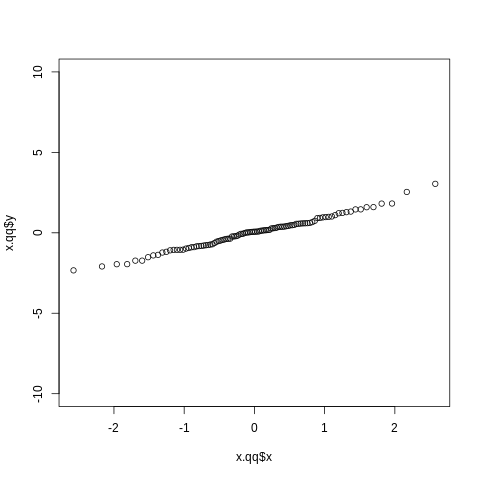

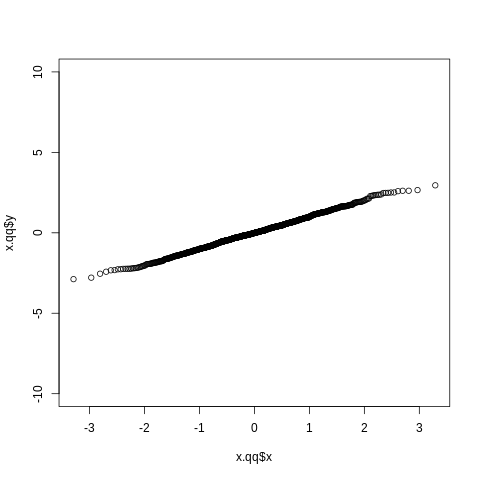

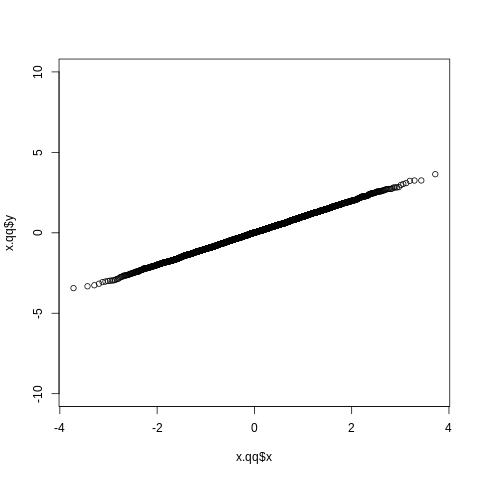

In [ ]:
%%R
envelope_m <- function(x){
  z <- (x - mean(x))/sqrt(var(x))  #  Стандартизация выборки
  x.qq <- qqnorm(z, plot.it = FALSE)
  x.qq <- lapply(x.qq, sort)
  plot(x.qq, ylim = c(-10, 10))
}

envelope_m(data1)
envelope_m(data2)
envelope_m(data3)
envelope_m(data4)
envelope_m(data5)

<Figure size 640x480 with 0 Axes>

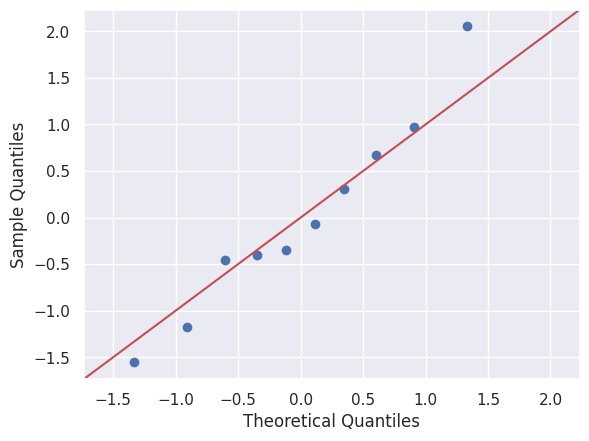

<Figure size 640x480 with 0 Axes>

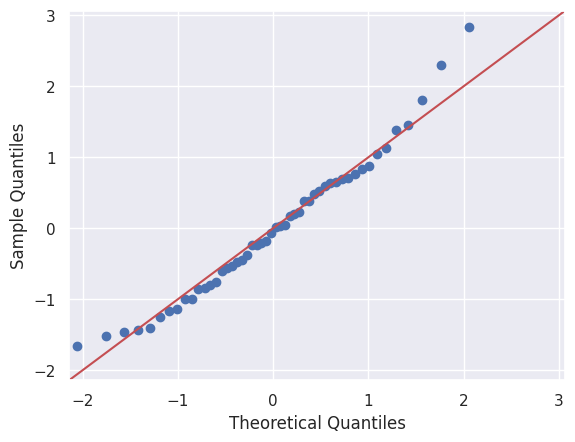

<Figure size 640x480 with 0 Axes>

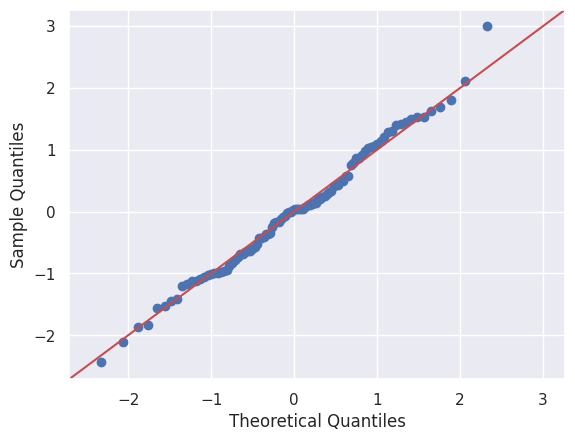

<Figure size 640x480 with 0 Axes>

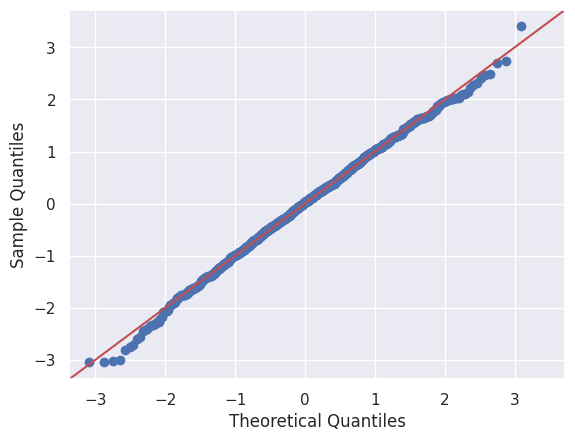

<Figure size 640x480 with 0 Axes>

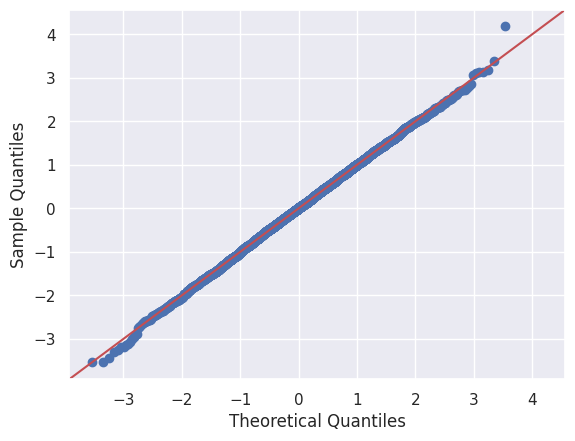

In [ ]:
# Python
for d in [data1, data2, data3, data4, data5]:
  d = (d - np.mean(d)) / np.std(d)
  plt.clf()
  sm.qqplot(d, line='45')
  plt.show()

## №5.2. Стандартные процедуры проверки гипотез о нормальности

### Критерий Колмогорова-Смирнова:

In [ ]:
# Python
from scipy.stats import kstest

print("1: ", kstest(data1, 'norm'))
print("2: ", kstest(data2, 'norm'))
print("3: ", kstest(data3, 'norm'))
print("4: ", kstest(data4, 'norm'))
print("5: ", kstest(data5, 'norm'))

1:  KstestResult(statistic=0.13280779482826044, pvalue=0.9844542011212841, statistic_location=-0.9653202936002971, statistic_sign=1)
2:  KstestResult(statistic=0.44321638215640174, pvalue=1.813762582581142e-09, statistic_location=-1.7892955168692133, statistic_sign=1)
3:  KstestResult(statistic=0.37313783112205023, pvalue=5.236384049803318e-13, statistic_location=0.7164324923597027, statistic_sign=-1)
4:  KstestResult(statistic=0.5952647474310038, pvalue=0.0, statistic_location=1.730894935227814, statistic_sign=-1)
5:  KstestResult(statistic=0.8175486481618346, pvalue=0.0, statistic_location=1.7761833377339622, statistic_sign=-1)


Гипотезу о нормальности распределения отклоняем для data4 и data5.

Одновыборный тест Колмогорова-Смирнова:

In [ ]:
%%R
ks.test(data4, "pnorm")


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data4
D = 0.59369, p-value < 2.2e-16
alternative hypothesis: two-sided



In [ ]:
%%R
ks.test(data5, "pnorm")


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  data5
D = 0.82178, p-value < 2.2e-16
alternative hypothesis: two-sided



Ни одну ни другую гипотезу о нормальности распределения не принимаем

Двухвыборный тест Колмогорова-Смирнова:

In [ ]:
%%R
ks.test(data1, data3)


	Exact two-sample Kolmogorov-Smirnov test

data:  data1 and data3
D = 0.73, p-value = 2.552e-05
alternative hypothesis: two-sided



In [ ]:
%%R
ks.test(data4, data5)


	Asymptotic two-sample Kolmogorov-Smirnov test

data:  data4 and data5
D = 0.2654, p-value < 2.2e-16
alternative hypothesis: two-sided



### Критерий Шапиро-Уилка:

In [ ]:
# Python
from scipy.stats import shapiro

print("1: ", shapiro(data1))
print("2: ", shapiro(data2))
print("3: ", shapiro(data3))
print("4: ", shapiro(data4))
print("5: ", shapiro(data5))

1:  ShapiroResult(statistic=0.9375928044319153, pvalue=0.5265522003173828)
2:  ShapiroResult(statistic=0.964231014251709, pvalue=0.13367655873298645)
3:  ShapiroResult(statistic=0.9936950206756592, pvalue=0.9262258410453796)
4:  ShapiroResult(statistic=0.9989286661148071, pvalue=0.8341863751411438)
5:  ShapiroResult(statistic=0.9995437860488892, pvalue=0.2890903055667877)


Для всех наборов p-value > 0.05, следовательно, принимаем нулевую гипотезу о нормальности распределения.

In [ ]:
%%R
shapiro.test(data1)


	Shapiro-Wilk normality test

data:  data1
W = 0.93517, p-value = 0.5007



In [ ]:
%%R
shapiro.test(data2)


	Shapiro-Wilk normality test

data:  data2
W = 0.9774, p-value = 0.4482



In [ ]:
%%R
shapiro.test(data3)


	Shapiro-Wilk normality test

data:  data3
W = 0.98977, p-value = 0.646



In [ ]:
%%R
shapiro.test(data4)


	Shapiro-Wilk normality test

data:  data4
W = 0.99854, p-value = 0.5804



In [ ]:
%%R
shapiro.test(data5)


	Shapiro-Wilk normality test

data:  data5
W = 0.9998, p-value = 0.9478



Для всех наборов p-value > 0.05, следовательно, принимаем нулевую гипотезу о нормальности распределения.

### Критерий Андерсона-Дарлинга:

In [ ]:
# Python
from scipy.stats import anderson

print("1: ", anderson(data1))
print("2: ", anderson(data2))
print("3: ", anderson(data3))
print("4: ", anderson(data4))
print("5: ", anderson(data5))

1:  AndersonResult(statistic=0.25143130127669977, critical_values=array([0.501, 0.57 , 0.684, 0.798, 0.95 ]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0164517815315949, scale=0.933282036788037)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
2:  AndersonResult(statistic=0.5241248392028197, critical_values=array([0.538, 0.613, 0.736, 0.858, 1.021]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.25133165873617286, scale=8.024884699841794)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
3:  AndersonResult(statistic=0.17366592385526758, critical_values=array([0.555, 0.632, 0.759, 0.885, 1.053]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.9295502531494315, scale=1.0509780224872174)
 success: True
 message: '`anderson` successfully fit the distribution to the data.

Полученные значения статистик меньше критических значений, значит, принимаем нулевую гипотезу о нормальности распределения.

In [ ]:
%%R
ad.test(data1)


	Anderson-Darling normality test

data:  data1
A = 0.36203, p-value = 0.3678



In [ ]:
%%R
ad.test(data2)


	Anderson-Darling normality test

data:  data2
A = 0.20538, p-value = 0.8644



In [ ]:
%%R
ad.test(data3)


	Anderson-Darling normality test

data:  data3
A = 0.25275, p-value = 0.7291



In [ ]:
%%R
ad.test(data4)


	Anderson-Darling normality test

data:  data4
A = 0.23215, p-value = 0.8002



In [ ]:
%%R
ad.test(data5)


	Anderson-Darling normality test

data:  data5
A = 0.24064, p-value = 0.7746



Для наборов data2 и data5 p-value < 0.05, следовательно, отклоняем нулевую гипотезу о нормальности распределения.

### Критерий Крамера фон Мизеса:

In [ ]:
# Python
from scipy.stats import cramervonmises

print("1: ", cramervonmises(data1, 'norm'))
print("2: ", cramervonmises(data2, 'norm'))
print("3: ", cramervonmises(data3, 'norm'))
print("4: ", cramervonmises(data4, 'norm'))
print("5: ", cramervonmises(data5, 'norm'))

1:  CramerVonMisesResult(statistic=0.028635177425606305, pvalue=0.9852551835629576)
2:  CramerVonMisesResult(statistic=3.417370412278889, pvalue=9.72936065046781e-10)
3:  CramerVonMisesResult(statistic=6.696065072251783, pvalue=7.920841760267194e-11)
4:  CramerVonMisesResult(statistic=122.05471550423461, pvalue=5.219192422689645e-08)
5:  CramerVonMisesResult(statistic=1289.9160715220462, pvalue=2.670169001461886e-07)


Для d1, d3, d4, d5 p-value > 0.05, следовательно, не отрицаем нулевую гипотезу о нормальности распределения. Для d2 p-value < 0.05, значит, гипотезу отклоняем.

In [ ]:
%%R
cvm.test(data1)


	Cramer-von Mises normality test

data:  data1
W = 0.05908, p-value = 0.3557



In [ ]:
%%R
cvm.test(data2)


	Cramer-von Mises normality test

data:  data2
W = 0.023901, p-value = 0.9212



In [ ]:
%%R
cvm.test(data3)


	Cramer-von Mises normality test

data:  data3
W = 0.03599, p-value = 0.7512



In [ ]:
%%R
cvm.test(data4)


	Cramer-von Mises normality test

data:  data4
W = 0.036145, p-value = 0.7514



In [ ]:
%%R
cvm.test(data5)


	Cramer-von Mises normality test

data:  data5
W = 0.036703, p-value = 0.7418



Для d1, d3, d4 p-value > 0.05, следовательно, не отрицаем нулевую гипотезу о нормальности распределения. Для d2 и d5 p-value < 0.05, значит, гипотезу отклоняем.

### Критерий Колмогорова-Смирнова в модификации Лиллиефорса и Шапиро-Франсия:

In [ ]:
# Python
from statsmodels.stats.diagnostic import lilliefors

print("1: ", lilliefors(data1, 'norm'))
print("2: ", lilliefors(data2, 'norm'))
print("3: ", lilliefors(data3, 'norm'))
print("4: ", lilliefors(data4, 'norm'))
print("5: ", lilliefors(data5, 'norm'))

1:  (0.15359023875564715, 0.7200245921167862)
2:  (0.09318568189913268, 0.34479341915316364)
3:  (0.040731101043042006, 0.9554491571733497)
4:  (0.023958201038515536, 0.23349647220896477)
5:  (0.008146705236636853, 0.5865455573924485)


Для всех наборов p-value > 0.05, следовательно, не отрицаем нулевую гипотезу о нормальности распределения.

In [ ]:
%%R
lillie.test(data1)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  data1
D = 0.21681, p-value = 0.2016



In [ ]:
%%R
lillie.test(data2)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  data2
D = 0.056167, p-value = 0.9585



In [ ]:
%%R
lillie.test(data3)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  data3
D = 0.053237, p-value = 0.6936



In [ ]:
%%R
lillie.test(data4)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  data4
D = 0.019637, p-value = 0.46



In [ ]:
%%R
lillie.test(data5)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  data5
D = 0.0076235, p-value = 0.6861



Для d1, d3, d4 p-value > 0.05, следовательно, не отрицаем нулевую гипотезу о нормальности распределения. Для d2 и d5 p-value < 0.05, значит, гипотезу отклоняем.

## №6. Продемонстрировать пример анализа данных с помощью графиков квантилей, метода огибающих, а также стандартных процедур проверки гипотез о нормальности. Рассмотреть выборки малого и умеренного объемов.

Отсюда и далее будем работать с базой данных карт общего набора. А именно с ее атакой. Распределения разделим на атаку всех карт набора из "марша короля лича" (малого) и всех карт


Малый объем: 39


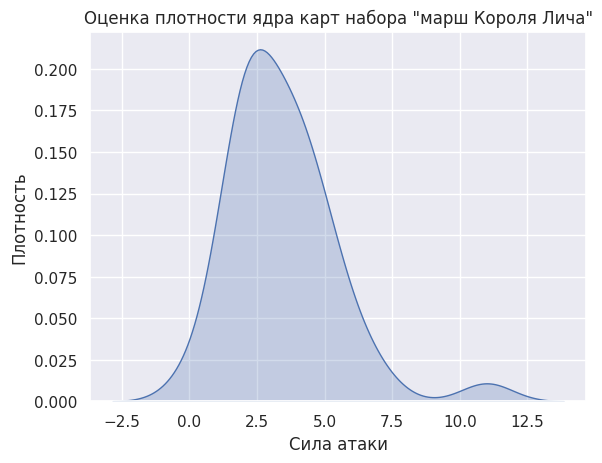

Умеренный объем: 1328


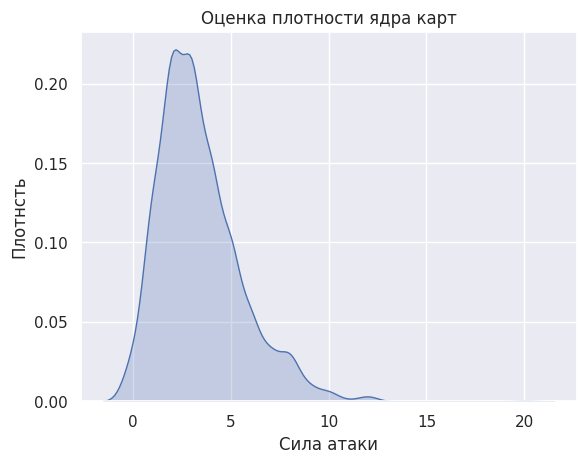

In [ ]:
# Python
attack_small = Neutral_df[Neutral_df['cardSet'] == "March of the Lich King"]['attack']
attack_big = Neutral_df['attack']

print("Малый объем:", len(attack_small))
sns.kdeplot(attack_small, fill=True)
plt.title('Оценка плотности ядра карт набора "марш Короля Лича"')
plt.xlabel('Сила атаки')
plt.ylabel('Плотность')
plt.show()

print("Умеренный объем:", len(attack_big))
sns.kdeplot(attack_big, fill=True)
plt.title('Оценка плотности ядра карт')
plt.xlabel('Сила атаки')
plt.ylabel('Плотнсть')
plt.show()

### Графики квантилей:

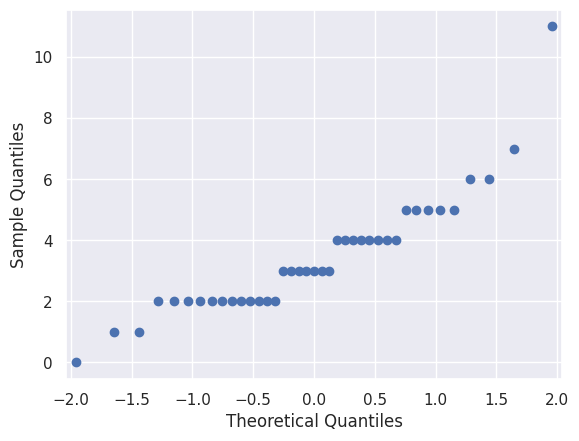

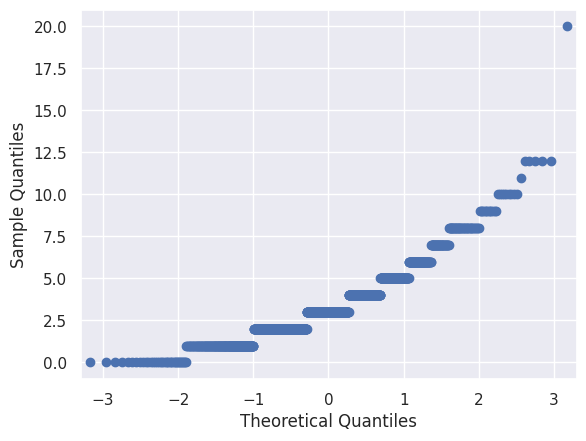

In [ ]:
# Python
sm.qqplot(attack_small)
sm.qqplot(attack_big)
plt.show()

### Гипотеза о нормальности:

**Критерий Колмогорова-Смирнова:**

In [ ]:
# Python
from scipy.stats import kstest
print(kstest(attack_small, 'norm'))
print(kstest(attack_big, 'norm'))

KstestResult(statistic=0.9003267911287438, pvalue=1.767974654586489e-39, statistic_location=2.0, statistic_sign=-1)
KstestResult(statistic=0.8183643258831461, pvalue=0.0, statistic_location=2.0, statistic_sign=-1)


p-value и для выборки малого объёма и для выборки умеренного объёма меньше 0.05, следовательно, отклоняем нулевую гипотезу о нормальности распределения по критерию Колмогорова-Смирнова.

**Критерий Андерсона-Дарлинга:**

In [ ]:
# Python
from scipy.stats import anderson
print(anderson(attack_small))
print(anderson(attack_big))

AndersonResult(statistic=1.344119802292731, critical_values=array([0.53 , 0.604, 0.725, 0.845, 1.005]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.4358974358974357, scale=1.9707715800626733)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=34.55889497409976, critical_values=array([0.574, 0.654, 0.785, 0.915, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=3.398343373493976, scale=2.1186145882369316)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


Не откланяем гипотезу для обоих выборок

**Критерий Крамера фон Мизеса:**

In [ ]:
# Python
from scipy.stats import cramervonmises
print(cramervonmises(attack_small, 'norm'))
print(cramervonmises(attack_big, 'norm'))

CramerVonMisesResult(statistic=11.287205037095212, pvalue=3.375104640213067e-10)
CramerVonMisesResult(statistic=359.10376206774595, pvalue=8.644995752593587e-08)


p-value и для выборки малого объёма и для выборки умеренного объёма меньше 0.05, следовательно, отклоняем нулевую гипотезу о нормальности распределения по критерию Крамера фон Мизеса.

**Критерий Колмогорова-Смирнова в модификации Лиллиефорса:**

In [ ]:
# Python
from statsmodels.stats.diagnostic import lilliefors
print(lilliefors(attack_small, 'norm'))
print(lilliefors(attack_big, 'norm'))

(0.1565800792607317, 0.01836980411304015)
(0.17999147007380328, 0.0009999999999998899)


p-value для выборки и малого и умеренного объёма меньше 0.05, следовательно, отклоняем нулевую гипотезу о нормальности распределения по критерию Колмогорова-Смирнова в модификации Лиллиефорса.

**Теперь проведем тоже самое на R**

In [ ]:
%%R
attack_small <- filter(Neutral_df, cardSet == 'March of the Lich King')$attack
attack_big <- Neutral_df$attack

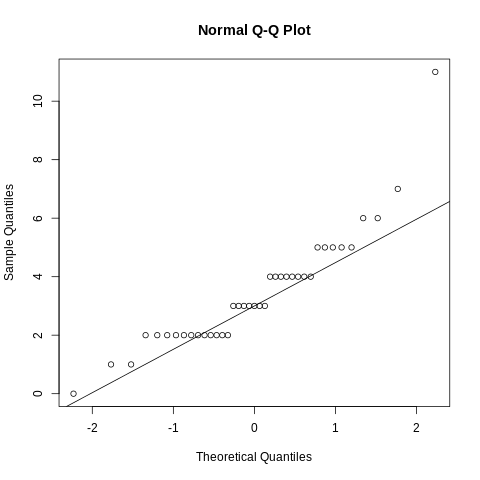

In [ ]:
%%R
qqgraph <- function(x){
  qqnorm(x)
  qqline(x)
}

qqgraph(attack_small)

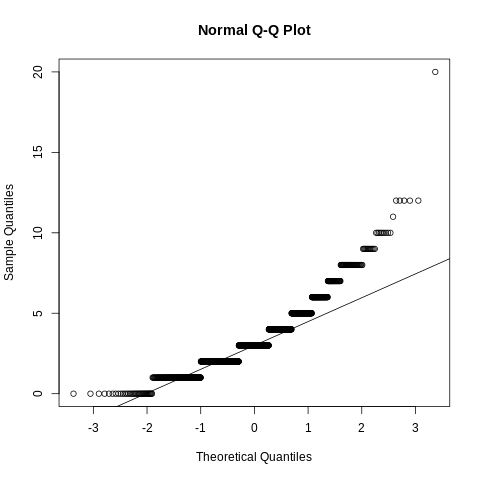

In [ ]:
%%R
qqgraph(attack_big)

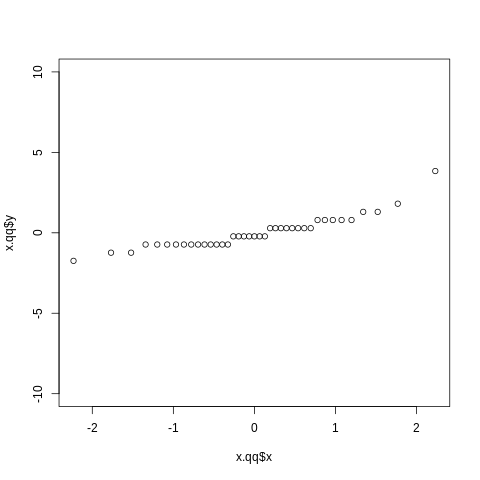

In [ ]:
%%R
envelope_m <- function(x){
  z <- (x - mean(x))/sqrt(var(x))  #  Стандартизация выборки
  x.qq <- qqnorm(z, plot.it = FALSE)
  x.qq <- lapply(x.qq, sort)
  plot(x.qq, ylim = c(-10, 10))
}
envelope_m(attack_small)

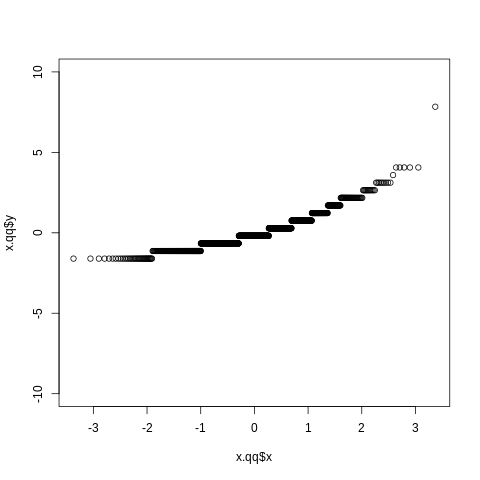

In [ ]:
%%R
envelope_m(attack_big)

**Критерий Колмогорова-Смирнова:**

In [ ]:
%%R
ks.test(attack_small, "pnorm")


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  attack_small
D = 0.90033, p-value < 2.2e-16
alternative hypothesis: two-sided



In [ ]:
%%R
ks.test(attack_big, "pnorm")


	Asymptotic one-sample Kolmogorov-Smirnov test

data:  attack_big
D = 0.81836, p-value < 2.2e-16
alternative hypothesis: two-sided



p-value и для выборки малого объёма и для выборки умеренного объёма меньше 0.05, следовательно, отклоняем нулевую гипотезу о нормальности распределения по критерию Колмогорова-Смирнова.

**Критерий Шапиро-Уилка:**

In [ ]:
%%R
shapiro.test(attack_small)


	Shapiro-Wilk normality test

data:  attack_small
W = 0.87318, p-value = 0.0004095



In [ ]:
%%R
shapiro.test(attack_big)


	Shapiro-Wilk normality test

data:  attack_big
W = 0.90438, p-value < 2.2e-16



p-value и для выборки малого объёма и для выборки умеренного объёма меньше 0.05, следовательно, отклоняем нулевую гипотезу о нормальности распределения по критерию Шапиро-Уилка.

**Критерий Андерсона-Дарлинга:**

In [ ]:
%%R
ad.test(attack_small)


	Anderson-Darling normality test

data:  attack_small
A = 1.3441, p-value = 0.001498



In [ ]:
%%R
ad.test(attack_big)


	Anderson-Darling normality test

data:  attack_big
A = 34.559, p-value < 2.2e-16



p-value и для выборки малого объёма и для выборки умеренного объёма меньше 0.05, следовательно, отклоняем нулевую гипотезу о нормальности распределения по критерию Андерсона-Дарлинга.

**Критерий Крамера фон Мизеса:**

In [ ]:
%%R
cvm.test(attack_small)


	Cramer-von Mises normality test

data:  attack_small
W = 0.21889, p-value = 0.002881



In [ ]:
%%R
cvm.test(attack_big)


	Cramer-von Mises normality test

data:  attack_big
W = 6.1535, p-value = 7.37e-10



p-value и для выборки малого объёма и для выборки умеренного объёма меньше 0.05, следовательно, отклоняем нулевую гипотезу о нормальности распределения по критерию Крамера фон Мизеса.

**Критерий Колмогорова-Смирнова в модификации Лиллиефорса:**

In [ ]:
%%R
lillie.test(attack_small)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  attack_small
D = 0.15658, p-value = 0.01701



In [ ]:
%%R
lillie.test(attack_big)


	Lilliefors (Kolmogorov-Smirnov) normality test

data:  attack_big
D = 0.17999, p-value < 2.2e-16



p-value и для выборки малого объёма и для выборки умеренного объёма меньше 0.05, следовательно, отклоняем нулевую гипотезу о нормальности распределения по критерию Колмогорова-Смирнова в модификации Лиллиефорса.

## №7. Продемонстрировать применение для проверки различных гипотез и различных доверительных уровней (0.9, 0.95, 0.99) следующих критериев:
- Стьюдента,  включая  односторонние  варианты,  когда проверяемая нулевая гипотеза заключается в том, что одно из сравниваемых средних  значений  больше  (или  меньше)  другого.  Реализовать  оценку мощности  критериев  при  заданном  объеме  выборки  или  определения объема выборки для достижения заданной мощности;
- Уилкоксона-Манна-Уитни (ранговые);
- Фишера,  Левене,  Бартлетта,  Флигнера-Килина  (проверка гипотез об однородности дисперсий).



### a. **Критерий Стьюдента:**

Нулевая гипотеза $H_0$: средние значения двух выборок равны (если параметр `alternative = 'two-sided'`) ИЛИ среднее первой выборки больше, чем среднее второй выборки (если параметр `alternative = 'greater'`).</br> Гипотеза не отвергается, если `p_value` > 0.05, и отвергается, если `p_value` < 0.05.

Проверим, как ведёт себя критерий Стьюдента, если в качестве предполагаемого среднего стоимости карт паладина взять среднее по всей выборке.

In [ ]:
%%R
print(paste('Среднее цены по всей выборке:', mean(Neutral_df$cost)))
print(paste('Среднее цены по выборке карт паладина:', mean(Paladin_df$cost)))

[1] "Среднее цены по всей выборке: 4.12772351615327"
[1] "Среднее цены по выборке карт паладина: 4.0679012345679"


In [ ]:
%%R
for (conf_level in c(0.9, 0.95, 0.99))
  print(t.test(Paladin_df$cost, mu = mean(Neutral_df$cost), conf.level = conf_level))


	One Sample t-test

data:  Paladin_df$cost
t = -0.29395, df = 161, p-value = 0.7692
alternative hypothesis: true mean is not equal to 4.127724
90 percent confidence interval:
 3.731215 4.404588
sample estimates:
mean of x 
 4.067901 


	One Sample t-test

data:  Paladin_df$cost
t = -0.29395, df = 161, p-value = 0.7692
alternative hypothesis: true mean is not equal to 4.127724
95 percent confidence interval:
 3.666002 4.469800
sample estimates:
mean of x 
 4.067901 


	One Sample t-test

data:  Paladin_df$cost
t = -0.29395, df = 161, p-value = 0.7692
alternative hypothesis: true mean is not equal to 4.127724
99 percent confidence interval:
 3.537402 4.598401
sample estimates:
mean of x 
 4.067901 



Гипотезу не отвергаем

Теперь используем двусторонний критерий для сравнения средних стоимости карты для классов мага и паладина. Их квантили +- похожи на гауссовские, средние равны и их можно считать независимыми, т.к. являются картами разных классов, а значит, критерий Стьюдента можно применять:

In [ ]:
%%R
print(mean(Paladin_df$cost))

[1] 4.067901


In [ ]:
%%R
print(mean(Mage_df$cost))

[1] 4.036585


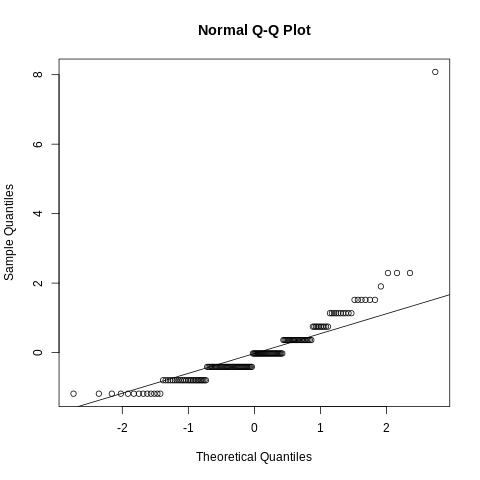

In [ ]:
%%R
qqgraph <- function(x){
  qqnorm(x)
  qqline(x)
}

qqgraph(scale(Paladin_df$cost))

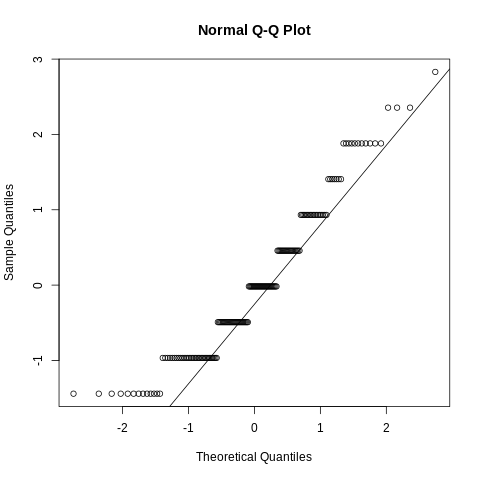

In [ ]:
%%R
qqgraph(scale(Mage_df$cost))

In [ ]:
#python
for conf in [0.9, 0.95, 0.99]:
  print("Доверительный уровень {}\n".format(conf))
  for alt in ['two-sided', 'greater']:
    print(
          ttest(
              Paladin_df["cost"],
              Mage_df["cost"],
              alternative=alt,
              confidence=conf
              )
          [[
              'CI{}%'.format(int(100*conf)),
              'p-val',
              'alternative'
              ]]
          )
    print()


Доверительный уровень 0.9

                                            CI90%     p-val alternative
T-test  [-0.4004534528093924, 0.4630851902378783]  0.904832   two-sided

                              CI90%     p-val alternative
T-test  [-0.30479831719819095, inf]  0.452416     greater

Доверительный уровень 0.95

                CI95%     p-val alternative
T-test  [-0.48, 0.55]  0.904832   two-sided

              CI95%     p-val alternative
T-test  [-0.4, inf]  0.452416     greater

Доверительный уровень 0.99

                                            CI99%     p-val alternative
T-test  [-0.6469888849757506, 0.7096206224042364]  0.904832   two-sided

                             CI99%     p-val alternative
T-test  [-0.5806843690597131, inf]  0.452416     greater



p-value 0.9, значит выборка хорошо показывает среднюю стоимость карт мага и паладина.

### b. **Критерий Уилкоксона-Манна-Уитни:**

Нулевая гипотеза $H_0$: распределения двух выборок не равны (параметр `alternative = 'two-sided`') ИЛИ распределение первой выборки стохастически больше распределения второй выборки (параметр `alternative = 'greater'`).</br>
Гипотеза отвергается, если `p_value` > 0.05, и не отвергается, если `p_value` < 0.05.

Далее тоже будут сравниваться выборки карт существ мага и паладина

In [ ]:
%%R
wilcox.test(
    x = Paladin_df$cost,
    y = Mage_df$cost,
    alternative = 'two.sided',
    exact = FALSE
    )


	Wilcoxon rank sum test with continuity correction

data:  Paladin_df$cost and Mage_df$cost
W = 13116, p-value = 0.842
alternative hypothesis: true location shift is not equal to 0



In [ ]:
# Python
print(
    mannwhitneyu(
      Paladin_df["cost"],
      Mage_df["cost"],
      alternative = 'two-sided'
    )
)

MannwhitneyuResult(statistic=13116.0, pvalue=0.841985926392405)


Как видим мы не отвергаем гипотезу о равенстве распределений выборок карт мага и паладина (p-value > 0.05)

Следовательно выборки стоимостей карт мага и паладина и в самом деле независимы и одинаково распределены с одинаковым средним. Рассмотрим теперь гипотезу об однородности их дисперсий:

### c. **Критерии Фишера, Левене, Бартлетта, Флигнера-Килина (проверка гипотез об однородности дисперсий):**

Нулевая гипотеза $H_0$: дисперсии двух выборок равны. </br>
Гипотеза не отвергается, если `p_value` > 0.05, и отвергается, если `p_value` < 0.05.

#### c.1. **Критерий Фишера:**

In [ ]:
%%R
var.test(
    Paladin_df$cost,
    Mage_df$cost
)


	F test to compare two variances

data:  Paladin_df$cost and Mage_df$cost
F = 1.5111, num df = 161, denom df = 163, p-value = 0.008917
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.109475 2.058605
sample estimates:
ratio of variances 
          1.511055 



Делаем вывод, что критерий Фишера отриицает однородность дисперсий.

#### c.2. **Критерий Левене:**

In [ ]:
%%R
f <- c(
    rep(1, length(Paladin_df$cost)),
    rep(2, length(Mage_df$cost))
)
leveneTest(
    c(Paladin_df$cost, Mage_df$cost),
    group = f
)

Levene's Test for Homogeneity of Variance (center = median)
       Df F value Pr(>F)
group   1  0.0149  0.903
      324               


In [ ]:
# Python
print(levene(
    Paladin_df["cost"],
    Mage_df["cost"])
)

LeveneResult(statistic=0.01489099585661338, pvalue=0.9029519646935729)


Делаем вывод, что критерий Левене не отриицает однородность дисперсий.

#### c.3. **Критерий Бартлетта:**

In [ ]:
%%R
print(
    bartlett.test(
        c(
            Paladin_df$cost,
            Mage_df$cost
        ),
        g = f
    )
)


	Bartlett test of homogeneity of variances

data:  c(Paladin_df$cost, Mage_df$cost) and f
Bartlett's K-squared = 6.8376, df = 1, p-value = 0.008926



In [ ]:
# Python
print(bartlett(
    Paladin_df["cost"],
    Mage_df["cost"])
)

BartlettResult(statistic=6.83758191843715, pvalue=0.008925958341795104)


Делаем вывод, что критерий Бартлетта отриицает однородность дисперсий.


#### c.4. **Критерий Флингера-Килина:**

In [ ]:
%%R
print(
    fligner.test(
        c(
            Paladin_df$cost,
            Mage_df$cost
        ),
        g = f
    )
)


	Fligner-Killeen test of homogeneity of variances

data:  c(Paladin_df$cost, Mage_df$cost) and f
Fligner-Killeen:med chi-squared = 0.80015, df = 1, p-value = 0.371



In [ ]:
# Python
print(fligner(
    Paladin_df["cost"],
    Mage_df["cost"])
)

FlignerResult(statistic=0.8001471555811683, pvalue=0.37104937606765653)


Делаем вывод, что критерий Флингера-Килина не отриицает однородность
дисперсий.

По итогу можно утверждать, что не отрицают однородности дисперсий 2 критерия из 4-ех. Тогда я могу утверждать, что дисперсии однородны у двух наборов карт

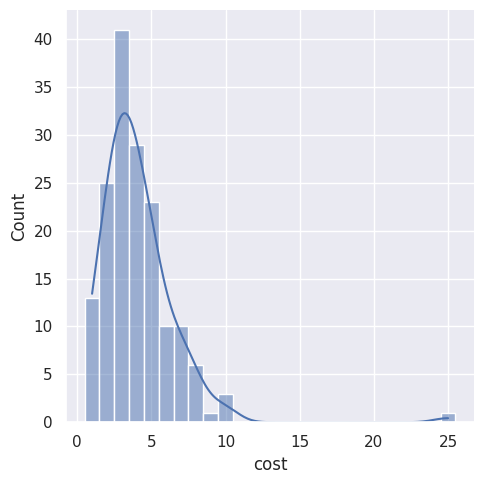

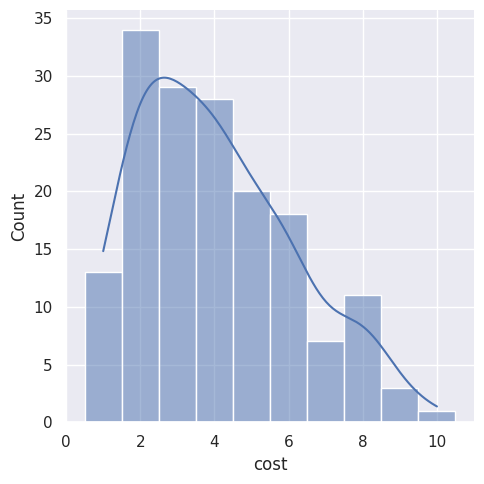

In [ ]:
# Python
sns.displot(
    x = 'cost',
    data = Paladin_df,
    discrete=True,
    kde = True,
)
sns.displot(
    x = 'cost',
    data = Mage_df,
    discrete=True,
    kde = True
)

## №8. Исследовать корреляционные взаимосвязи в данных с помощью коэффициентов корреляции Пирсона, Спирмена и Кендалла.

In [ ]:
%%R
attack_tmp <- Neutral_df$attack
health_tmp <- Neutral_df$health
cost_tmp   <- Neutral_df$cost

### **Коэффициент корреляции Пирсона:**

In [ ]:
# Python
from scipy.stats import pearsonr

print('attack and health:', pearsonr(Neutral_df['attack'], Neutral_df['health']))
print('attack and cost:  ', pearsonr(Neutral_df['attack'], Neutral_df['cost']))

attack and health: PearsonRResult(statistic=0.608851399212566, pvalue=1.5782863873929047e-135)
attack and cost:   PearsonRResult(statistic=0.7320296014116956, pvalue=2.8807709003252307e-223)


In [ ]:
%%R
print(cor.test(attack_tmp, health_tmp, method = 'pearson'))
print(cor.test(attack_tmp, cost_tmp, method = 'pearson'))


	Pearson's product-moment correlation

data:  attack_tmp and health_tmp
t = 27.948, df = 1326, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.5738536 0.6416294
sample estimates:
      cor 
0.6088514 


	Pearson's product-moment correlation

data:  attack_tmp and cost_tmp
t = 39.127, df = 1326, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7060394 0.7560505
sample estimates:
      cor 
0.7320296 



Получили, что выбранные мною данные не коррелируют

###**Коэффициент корреляции Спирмена:**

In [ ]:
# Python
from scipy.stats import spearmanr

print('attack and health:', spearmanr(Neutral_df['attack'], Neutral_df['health']))
print('attack and cost:  ', spearmanr(Neutral_df['attack'], Neutral_df['cost']))

attack and health: SignificanceResult(statistic=0.5645153592970621, pvalue=1.2619342373431255e-112)
attack and cost:   SignificanceResult(statistic=0.7413192994032661, pvalue=6.84309335903792e-232)


In [ ]:
%%R
print(cor.test(attack_tmp, health_tmp, method = 'spearman'))
print(cor.test(attack_tmp, cost_tmp, method = 'spearman'))


	Spearman's rank correlation rho

data:  attack_tmp and health_tmp
S = 169986946, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5645154 


	Spearman's rank correlation rho

data:  attack_tmp and cost_tmp
S = 100973348, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7413193 



Аналогично получаем схожие значения

###**Коэффициент корреляции Кендалла:**

In [ ]:
# Python
from scipy.stats import kendalltau

print('attack and health:', kendalltau(Neutral_df['attack'], Neutral_df['health']))
print('attack and cost:  ', kendalltau(Neutral_df['attack'], Neutral_df['cost']))

attack and health: SignificanceResult(statistic=0.4646932042145758, pvalue=1.4634269067738112e-109)
attack and cost:   SignificanceResult(statistic=0.6272328397430864, pvalue=1.0512061575870575e-197)


In [ ]:
%%R
print(cor.test(attack_tmp, health_tmp, method = 'kendall'))
print(cor.test(attack_tmp, cost_tmp, method = 'kendall'))


	Kendall's rank correlation tau

data:  attack_tmp and health_tmp
z = 22.238, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.4646932 


	Kendall's rank correlation tau

data:  attack_tmp and cost_tmp
z = 29.998, p-value < 2.2e-16
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.6272328 



Снова получили схожие результаты и на R, и на Python.

**Вывод:** атака не коррелирует ни с количеством здоровья, ни со стоимостью карты

## №9. Продемонстрировать использование методов
- хи-квадрат,
- точного теста Фишера,
- теста МакНемара,
- теста Кохрана-Мантеля-Хензеля.

### **$\chi$-квадрат:**

Давайте мы посчитаем чило карт, которе получал маг за каждое дополнение и за гипотезу $H_0$ возьмем, что распределние является равномерным.

Для этого посчитаем число дополнений и выведем число карт в каждой:

In [ ]:
# Python
print("Number of card sets ", Paladin_df.nunique()["cardSet"])
obs = Paladin_df.value_counts("cardSet")
print(obs)

Number of card sets  31
cardSet
TITANS                           9
March of the Lich King           9
Voyage to the Sunken City        8
Caverns of Time                  7
Descent of Dragons               7
Showdown in the Badlands         7
Murder at Castle Nathria         7
Madness At The Darkmoon Faire    7
Scholomance Academy              7
The Witchwood                    6
Knights of the Frozen Throne     6
Saviors of Uldum                 6
United in Stormwind              6
Fractured in Alterac Valley      6
Forged in the Barrens            6
Festival of Legends              6
Goblins vs Gnomes                5
The Boomsday Project             5
Rastakhan's Rumble               5
Ashes of Outland                 5
The Grand Tournament             4
Mean Streets of Gadgetzan        4
Rise of Shadows                  4
Kobolds & Catacombs              4
Journey to Un'Goro               4
Whispers of the Old Gods         3
One Night in Karazhan            2
Galakrond's Awakening  

In [ ]:
# Python
p = Paladin_df.shape[0] / Paladin_df.nunique()["cardSet"]
exp = [p] * Paladin_df.nunique()["cardSet"]

chisquare(obs, exp)

Power_divergenceResult(statistic=25.148148148148145, pvalue=0.7178006386629253)

In [ ]:
%%R
p <- table(Paladin_df$cardSet) / length(Paladin_df$cardSet)
obs <- table(Paladin_df$cardSet)

chisq.test(obs/sum(obs), p=p)


	Chi-squared test for given probabilities

data:  obs/sum(obs)
X-squared = 0, df = 30, p-value = 1



Критерий $\chi$-квадрат не отвергает гипотезу о равномерности распределения выхода карт на паладина.

### **Точный тест Фишера:**

Проверим однородность данных по разным дополнениям:

In [ ]:
# Python
attack_MotLK = Neutral_df[Neutral_df['cardSet'] == "March of the Lich King"]["attack"].mean()
attack_BM = Neutral_df[Neutral_df['cardSet'] == "Blackrock Mountain"]["attack"].mean()
attack_C = Neutral_df[Neutral_df['cardSet'] == "Classic"]["attack"].mean()

cost_MotLK = Neutral_df[Neutral_df['cardSet'] == "March of the Lich King"]["cost"].mean()
cost_BM = Neutral_df[Neutral_df['cardSet'] == "Blackrock Mountain"]["cost"].mean()
cost_C = Neutral_df[Neutral_df['cardSet'] == "Classic"]["cost"].mean()

health_MotLK = Neutral_df[Neutral_df['cardSet'] == "March of the Lich King"]["health"].mean()
health_BM = Neutral_df[Neutral_df['cardSet'] == "Blackrock Mountain"]["health"].mean()
health_C = Neutral_df[Neutral_df['cardSet'] == "Classic"]["health"].mean()

k = [[attack_MotLK, attack_BM], [cost_MotLK, cost_BM]]
print(k)

k1 = [[attack_MotLK, attack_C], [cost_MotLK, cost_C]]
print(k1)

k2 = [[attack_BM, attack_C], [cost_BM, cost_C]]
print(k2)

k3 = [[attack_BM, attack_C], [health_BM, health_C]]
print(k3)

k4 = [[attack_BM, attack_MotLK], [health_BM, health_MotLK]]
print(k4)

k5 = [[attack_MotLK, attack_C], [health_MotLK, health_C]]
print(k5)

[[3.4358974358974357, 5.083333333333333], [3.6923076923076925, 5.583333333333333]]
[[3.4358974358974357, 3.404255319148936], [3.6923076923076925, 3.851063829787234]]
[[5.083333333333333, 3.404255319148936], [5.583333333333333, 3.851063829787234]]
[[5.083333333333333, 3.404255319148936], [5.083333333333333, 3.9148936170212765]]
[[5.083333333333333, 3.4358974358974357], [5.083333333333333, 3.948717948717949]]
[[3.4358974358974357, 3.404255319148936], [3.948717948717949, 3.9148936170212765]]


In [ ]:
# Python
from scipy.stats import fisher_exact

print(fisher_exact(k))
print(fisher_exact(k1))
print(fisher_exact(k2))
print(fisher_exact(k3))
print(fisher_exact(k4))
print(fisher_exact(k5))

SignificanceResult(statistic=1.0, pvalue=1.0)
SignificanceResult(statistic=1.0, pvalue=1.0)
SignificanceResult(statistic=1.0, pvalue=1.0)
SignificanceResult(statistic=1.0, pvalue=1.0)
SignificanceResult(statistic=1.0, pvalue=1.0)
SignificanceResult(statistic=1.0, pvalue=1.0)


In [ ]:
%%R

attack_MotLK <- Neutral_df[which(Neutral_df$cardSet == "March of the Lich King"), ]$attack
attack_BM <- Neutral_df[which(Neutral_df$cardSet == "Blackrock Mountain"), ]$attack
attack_C <- Neutral_df[which(Neutral_df$cardSet == "Classic"), ]$attack

cost_MotLK <- Neutral_df[which(Neutral_df$cardSet == "March of the Lich King"), ]$cost
cost_BM <- Neutral_df[which(Neutral_df$cardSet == "Blackrock Mountain"), ]$cost
cost_C <- Neutral_df[which(Neutral_df$cardSet == "Classic"), ]$cost

health_MotLK <- Neutral_df[which(Neutral_df$cardSet == "March of the Lich King"), ]$health
health_BM <- Neutral_df[which(Neutral_df$cardSet == "Blackrock Mountain"), ]$health
health_C <- Neutral_df[which(Neutral_df$cardSet == "Classic"), ]$health


k <- matrix(c(mean(attack_MotLK), mean(attack_BM), mean(cost_MotLK), mean(cost_BM)), nrow <- 2, ncol <- 2, byrow <- TRUE, dimnames <- list(c("March of the Lich King", "Blackrock Mountain"), c("attack", "cost")))

k1 <- matrix(c(mean(attack_MotLK), mean(attack_C), mean(cost_MotLK), mean(cost_C)), nrow <- 2, ncol <- 2, byrow <- TRUE, dimnames <- list(c("March of the Lich King", "Classic"), c("attack", "cost")))

k2 <- matrix(c(mean(attack_BM), mean(attack_C), mean(cost_BM), mean(cost_C)), nrow <- 2, ncol <- 2, byrow <- TRUE, dimnames <- list(c("Blackrock Mountain", "Classic"), c("attack", "cost")))

k3 <- matrix(c(mean(attack_BM), mean(attack_C), mean(health_BM), mean(health_C)), nrow <- 2, ncol <- 2, byrow <- TRUE, dimnames <- list(c("Blackrock Mountain", "Classic"), c("attack", "health")))

k4 <- matrix(c(mean(attack_BM), mean(attack_MotLK), mean(health_BM), mean(health_MotLK)), nrow <- 2, ncol <- 2, byrow <- TRUE, dimnames <- list(c("Blackrock Mountain", "March of the Lich King"), c("attack", "health")))

k5 <- matrix(c(mean(attack_MotLK), mean(attack_C), mean(health_MotLK), mean(health_C)), nrow <- 2, ncol <- 2, byrow <- TRUE, dimnames <- list(c("March of the Lich King", "Classic"), c("attack", "health")))

In [ ]:
%%R
print(fisher.test(k))
print(fisher.test(k1))
print(fisher.test(k2))
print(fisher.test(k3))
print(fisher.test(k4))
print(fisher.test(k5))


	Fisher's Exact Test for Count Data

data:  k
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.08679189 8.68004488
sample estimates:
odds ratio 
 0.9052787 


	Fisher's Exact Test for Count Data

data:  k1
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.07674974 13.02935967
sample estimates:
odds ratio 
         1 


	Fisher's Exact Test for Count Data

data:  k2
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.1152068 11.5218143
sample estimates:
odds ratio 
  1.104632 


	Fisher's Exact Test for Count Data

data:  k3
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
  0.1324252 14.2656768
sample estimates:
odds ratio 
  1.310915 


	Fisher's Exact Test for Count Data

data:  k4
p-value = 1
alternative hypothesis: true odds ratio is not equal to 1
95 percent confid

Видим, что гипотезу о независимости случайных величин точный тест фишера не отвергает.

### **Тест МакНемара:**

In [ ]:
# Python
from statsmodels.stats.contingency_tables import mcnemar

print(mcnemar(k, exact=False))
print(mcnemar(k1, exact=False))
print(mcnemar(k2, exact=False))
print(mcnemar(k3, exact=False))
print(mcnemar(k4, exact=False))
print(mcnemar(k5, exact=False))

pvalue      0.8949862436964251
statistic   0.01742334850442954
pvalue      0.7892736958895554
statistic   0.07142463507286459
pvalue      0.694099923738465
statistic   0.15468275388294014
pvalue      0.8156899085714964
statistic   0.05433191548623854
pvalue      0.8244556464728349
statistic   0.049203179564353376
pvalue      0.8665883808970014
statistic   0.0282218210646887


In [ ]:
%%R
print(mcnemar.test(k))
print(mcnemar.test(k1))
print(mcnemar.test(k2))
print(mcnemar.test(k3))
print(mcnemar.test(k4))
print(mcnemar.test(k5))


	McNemar's Chi-squared test with continuity correction

data:  k
McNemar's chi-squared = 0.017423, df = 1, p-value = 0.895


	McNemar's Chi-squared test with continuity correction

data:  k1
McNemar's chi-squared = 0.071425, df = 1, p-value = 0.7893


	McNemar's Chi-squared test with continuity correction

data:  k2
McNemar's chi-squared = 0.15468, df = 1, p-value = 0.6941


	McNemar's Chi-squared test with continuity correction

data:  k3
McNemar's chi-squared = 0.054332, df = 1, p-value = 0.8157


	McNemar's Chi-squared test with continuity correction

data:  k4
McNemar's chi-squared = 0.049203, df = 1, p-value = 0.8245


	McNemar's Chi-squared test with continuity correction

data:  k5
McNemar's chi-squared = 0.028222, df = 1, p-value = 0.8666



Получается, что гипотезу о равенстве двух предельные вероятности для каждого результата не отвергаем для каждой матрицы

## №10.  Проверить наличие мультиколлинеарности в данных с помощью
- корреляционной матрицы
- фактора инфляции дисперсии.

### **Корреляционная матрица:**

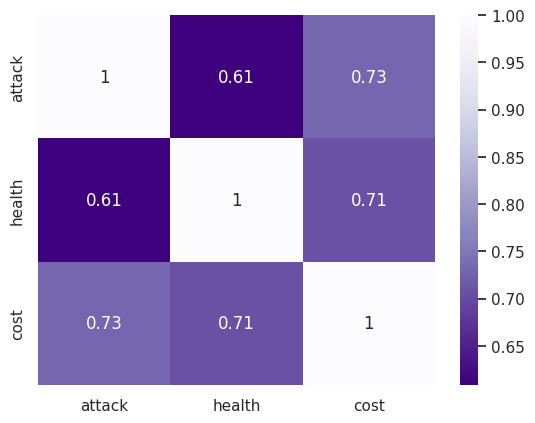

In [ ]:
# Python
import pandas as pd

data = Neutral_df[["attack", "health", "cost"]]

fig = plt.figure()
sns.heatmap(data.corr(), cmap="Purples_r", annot=True)

plt.show()

Проделаем то же самое на R:

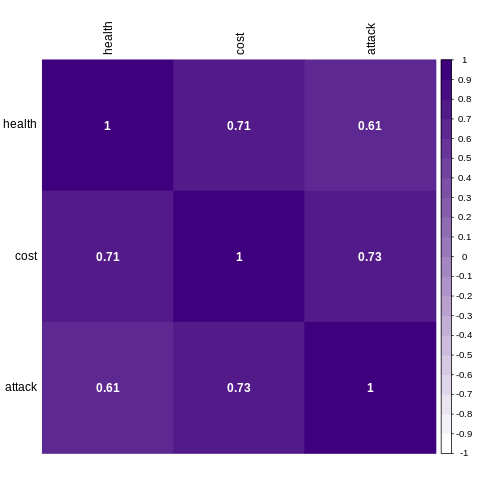

In [ ]:
%%R
data3 <- Neutral_df[, c(8, 9, 10)]

MATRIX <- cor(data3)
col4 <- colorRampPalette(c("white", "#3F007D"))

corrplot(MATRIX, method = "color", col = col4(20), cl.length = 21,
         order = "AOE",  tl.col = "black", addCoef.col = "white")

Существуют наибольшая корреляция между attack и cost. В самом деле, дорогие существа сильнее слабых. максимальная положительная корреляция у cost, она связана со всеми характеристиками.

### **Фактор инфляции дипсперсии:**

**Фактор инфляции дисперсии** — это мера мультиколлинеарности, которая существует в наборе переменных, участвующих в множественных регрессиях.

Как правило, значение vif выше 10 указывает на высокую корреляцию с другими независимыми переменными.

In [ ]:
%%R
model <- lm(cost ~ attack + health, data=Neutral_df)
print(VIF(model))

 attack  health 
1.58722 1.58722 


In [ ]:
# Python
for fact in ["attack", "health"]:
    print(fact, "/ price VIF = ", variance_inflation_factor(Neutral_df[["cost", fact]], 0))

attack / price VIF =  7.385085385840667
health / price VIF =  7.397925630223225


Из результатов можем сделать вывод, что атака и здоровье карты одинаково сильно коррелируют со стоимостью. Что совпадает с реальностью: карты с высокой ценой (почти) всегда имеют большие показатели здоровья и атаки, чем карты с низкой

## №11.  Исследовать  зависимости  в  данных  с  помощью  дисперсионного анализа.

Проверим, зависит ли стоимость карты от ее редкости:

In [ ]:
# Python

cost_Rare = Neutral_df[Neutral_df["rarity"] == "Rare"]["cost"]
cost_Common = Neutral_df[Neutral_df["rarity"] == "Common"]["cost"]

health_Rare = Neutral_df[Neutral_df["rarity"] == "Rare"]["health"]
health_Common = Neutral_df[Neutral_df["rarity"] == "Common"]["health"]

print(stats.f_oneway(cost_Rare, cost_Common))
print(stats.f_oneway(health_Rare, health_Common))

F_onewayResult(statistic=4.049254336929079, pvalue=0.04450404439553491)
F_onewayResult(statistic=2.8099588185859763, pvalue=0.09404635606144353)


`pvalue` < 0.05 для пары редких и обычных карт. Можем сделать вывод о том, что гипотезу о независимости здоровья карты от ее редкости отвергаем.

Что касается стоимости карты - `pvalue` > 0.05, значит гипотезу о независимости стоимости карты от ее редкости не отвергаем.

### **Однофакторный дисперсионный анализ:**

In [ ]:
%%R
summary(aov(cost ~ rarity, data = Paladin_df))

             Df Sum Sq Mean Sq F value  Pr(>F)    
rarity        4  139.8   34.96   5.836 0.00021 ***
Residuals   157  940.4    5.99                    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


p-value < 0.05 значит, независимость отвергается.

####**Линейная модель (Однофакторный дисперсионный анализ):**

In [ ]:
%%R
A1 <- lm(Neutral_df$health ~ Neutral_df$cost)
summary(A1)


Call:
lm(formula = Neutral_df$health ~ Neutral_df$cost)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5100 -0.9136 -0.0604  0.7928 15.9396 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      1.19795    0.09304   12.88   <2e-16 ***
Neutral_df$cost  0.71560    0.01969   36.34   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.652 on 1329 degrees of freedom
Multiple R-squared:  0.4984,	Adjusted R-squared:  0.498 
F-statistic:  1321 on 1 and 1329 DF,  p-value: < 2.2e-16



И здесь независимость отвергается.

####**Таблица дисперсионного анализа:**

In [ ]:
%%R
anova(A1)

Analysis of Variance Table

Response: Neutral_df$health
                  Df Sum Sq Mean Sq F value    Pr(>F)    
Neutral_df$cost    1 3603.2  3603.2  1320.6 < 2.2e-16 ***
Residuals       1329 3626.1     2.7                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


###**Двухфакторный дисперсионный анализ:**

In [ ]:
%%R
A2 <- lm(cost ~ attack + health, data=Neutral_df)
print(summary(A2))
print(anova(A2))


Call:
lm(formula = cost ~ attack + health, data = Neutral_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2554  -0.7868  -0.1954   0.5941  11.9025 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.65891    0.08087   8.147  8.5e-16 ***
attack       0.52123    0.02243  23.241  < 2e-16 ***
health       0.40859    0.02037  20.062  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.374 on 1328 degrees of freedom
Multiple R-squared:  0.6434,	Adjusted R-squared:  0.6429 
F-statistic:  1198 on 2 and 1328 DF,  p-value: < 2.2e-16

Analysis of Variance Table

Response: cost
            Df Sum Sq Mean Sq F value    Pr(>F)    
attack       1 3767.0  3767.0  1994.0 < 2.2e-16 ***
health       1  760.4   760.4   402.5 < 2.2e-16 ***
Residuals 1328 2508.9     1.9                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


И тут независимость отвергается.

###**Трёхфакторный дисперсионный анализ:**

Я взял в качестве одного из показателей уникальный номер карты: он, очевидно, не зависит от ее показателей.

In [ ]:
%%R
A2 <- lm(cost ~ attack + health + dbfId, data=Neutral_df)
print(summary(A2))
print(anova(A2))


Call:
lm(formula = cost ~ attack + health + dbfId, data = Neutral_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-15.2485  -0.7873  -0.2063   0.5790  11.9395 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.487e-01  1.097e-01   6.824 1.34e-11 ***
attack       5.204e-01  2.243e-02  23.195  < 2e-16 ***
health       4.085e-01  2.036e-02  20.059  < 2e-16 ***
dbfId       -1.651e-06  1.363e-06  -1.211    0.226    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.374 on 1327 degrees of freedom
Multiple R-squared:  0.6438,	Adjusted R-squared:  0.643 
F-statistic: 799.6 on 3 and 1327 DF,  p-value: < 2.2e-16

Analysis of Variance Table

Response: cost
            Df Sum Sq Mean Sq   F value Pr(>F)    
attack       1 3767.0  3767.0 1994.6882 <2e-16 ***
health       1  760.4   760.4  402.6408 <2e-16 ***
dbfId        1    2.8     2.8    1.4671  0.226    
Residuals 1327 2506.1     1.9                  

Результаты схожи с предыдущим примером, но гипотезу о независимости индека карты и ее стоимоти мы не отвергаем, что совпадает с реальностью.

## №12.   Подогнать регрессионные модели  к данным, а также оценить качество подобной аппроксимации

###**Линейная регрессионная модель:**

**Модель линейной регрессии** устанавливает связь между зависимой переменной ( y ) и по крайней мере одной независимой переменной ( x ) как:

$$ \widetilde{y} = b_1 \cdot x + b_0 $$

В методе OLS мы должны выбрать $b_1$ значения, а также $b_0$ таким образом, чтобы минимизировать общую сумму квадратов разницы между вычисленными и наблюдаемыми значениями y. </br>
**Формула для OLS**:

$$ S = \sum_{i=1}^{n} (y_i - \widetilde{y_i})^2 = \sum_{i=1}^{n} (y_i - b_1 \cdot x - b_0)^2 = \sum_{i=1}^{n} (\widetilde{\xi})^2 = min $$

Где, </br>
$\widetilde{y_i}$ = прогнозируемое значение для i-го наблюдения </br>
$y_i$ = фактическое значение для i-го наблюдения </br>
$\widetilde{\xi}$ = ошибка / невязка для i-го наблюдения </br>
$n$ = общее количество наблюдений </br>

Чтобы получить значения $b_1$, а также  $b_0$, которые минимизируют $S$, мы можем взять частную производную для каждого коэффициента и приравнять ее к нулю.

Будем рассматривать множество нейтральных карт, их атаку и здоровье

In [ ]:
# Python
x = Neutral_df["attack"]
y = Neutral_df["health"]

x = sm.add_constant(x)
result = sm.OLS(y, x).fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 health   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     780.4
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          1.71e-135
Time:                        21:01:14   Log-Likelihood:                -2707.3
No. Observations:                1331   AIC:                             5419.
Df Residuals:                    1329   BIC:                             5429.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8741      0.096     19.515      0.0

Получили следующую формулу: $$health =  0.6698 \cdot attack + 1.8741$$

In [ ]:
%%R
lin <- lm(Neutral_df$health ~ Neutral_df$attack)
summary(lin)


Call:
lm(formula = Neutral_df$health ~ Neutral_df$attack)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.2326 -1.2137 -0.2232  0.7863 10.7863 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        1.87411    0.09603   19.52   <2e-16 ***
Neutral_df$attack  0.66981    0.02398   27.94   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.851 on 1329 degrees of freedom
Multiple R-squared:   0.37,	Adjusted R-squared:  0.3695 
F-statistic: 780.4 on 1 and 1329 DF,  p-value: < 2.2e-16



Получили следующую формулу: $$health =  0.66981 \cdot attack + 1.87411$$ Формула совпадает с той, что мы получили ранее, используя Python.

Другие виды регрессий:
- Логистическая регрессия
- Полиномиальная регрессия
- Квантильная регрессия
- Лассо-регрессия / Ридж-регрессия
- Метод главных компонент
- Регрессия наименьших частичных квадратов
- Порядковая регрессия
- Регрессия Пуассона / Отрицательная биноминальная регрессия
- Регрессия Кокса

###**Полиномиальная регрессионная модель:**

В статистике, полиномиальная регрессия - это форма регрессионного анализа, в которой взаимосвязь между независимая переменная x и зависимая переменная y моделируются как полином $n$-й степени от $x$. Полиномиальная регрессия соответствует нелинейной зависимости между значением $x$ и соответствующим условным средним $y$, обозначенным $E (y | x)$. Хотя полиномиальная регрессия соответствует нелинейной модели данных, как проблема статистической оценки она является линейной в том смысле, что функция регрессии $E (y | x)$ линейна относительно неизвестных параметров, которые оцениваются на основе данных . По этой причине полиномиальная регрессия считается частным случаем множественной линейной регрессии.

Этот тип регрессии принимает форму:

$$Y = β_0 + β_1 X_1 + β_2 X^2 + … + β_n X^n + ε$$

где n — «степень» многочлена.

In [ ]:
%%R
polynomial = lm(Neutral_df$health ~ poly(Neutral_df$attack, degree = 3, raw = T))
summary(polynomial)


Call:
lm(formula = Neutral_df$health ~ poly(Neutral_df$attack, degree = 3, 
    raw = T))

Residuals:
    Min      1Q  Median      3Q     Max 
-5.5054 -1.2357 -0.2357  0.7643 10.7643 

Coefficients:
                                                Estimate Std. Error t value
(Intercept)                                    2.5780225  0.1725845  14.938
poly(Neutral_df$attack, degree = 3, raw = T)1  0.2084403  0.1087744   1.916
poly(Neutral_df$attack, degree = 3, raw = T)2  0.0632843  0.0182769   3.463
poly(Neutral_df$attack, degree = 3, raw = T)3 -0.0015436  0.0008028  -1.923
                                              Pr(>|t|)    
(Intercept)                                    < 2e-16 ***
poly(Neutral_df$attack, degree = 3, raw = T)1 0.055546 .  
poly(Neutral_df$attack, degree = 3, raw = T)2 0.000552 ***
poly(Neutral_df$attack, degree = 3, raw = T)3 0.054719 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.831 on 1327 degrees of freedom

$$health =  2.5780225 + 0.2084403 \cdot attack + 0.0632843 \cdot attack^2 - 0.0015436 \cdot attack^3$$

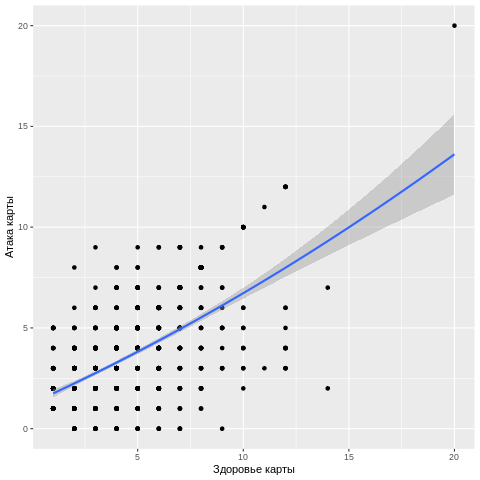

In [ ]:
%%R
ggplot(Neutral_df, aes(x=Neutral_df$health, y=Neutral_df$attack)) +
          geom_point() +
          stat_smooth(method='lm', formula = y ~ poly(x,2), size = 1) +
          xlab('Здоровье карты') +
          ylab('Атака карты')

Наблюдаем разброс здоровья относительно силы, и т.к. распределение у нас дискретное, то о нормальной аппроксимации мы говорить не можем

## Альтернатива

###**Линейная регрессионная модель:**

In [ ]:
# Python
x = df["Annual Income (k$)"]
y = df["Spending Score (1-100)"]

x = sm.add_constant(x)
result = sm.OLS(y, x).fit()

print(result.summary())

                              OLS Regression Results                              
Dep. Variable:     Spending Score (1-100)   R-squared:                       0.000
Model:                                OLS   Adj. R-squared:                 -0.005
Method:                     Least Squares   F-statistic:                   0.01942
Date:                    Sun, 18 Feb 2024   Prob (F-statistic):              0.889
Time:                            21:01:58   Log-Likelihood:                -933.53
No. Observations:                     200   AIC:                             1871.
Df Residuals:                         198   BIC:                             1878.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

Получили следующую формулу: $$Spending Score =  0.0097 \cdot Annual Income + 49.6104$$

In [ ]:
%%R
lin <- lm(df$Spending.Score..1.100. ~ df$Annual.Income..k..)
summary(lin)


Call:
lm(formula = df$Spending.Score..1.100. ~ df$Annual.Income..k..)

Residuals:
    Min      1Q  Median      3Q     Max 
-49.370 -15.613  -0.209  22.642  49.205 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           49.610358   4.610287  10.761   <2e-16 ***
df$Annual.Income..k..  0.009736   0.069870   0.139    0.889    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 25.89 on 198 degrees of freedom
Multiple R-squared:  9.807e-05,	Adjusted R-squared:  -0.004952 
F-statistic: 0.01942 on 1 and 198 DF,  p-value: 0.8893



Получили следующую формулу: $$Spending Score =  0.009736 \cdot Annual Income + 49.610358$$
Она совпадает с формулой, полученной на python

###**Полиномиальная регрессионная модель:**

In [ ]:
%%R
polynomial = lm(df$Spending.Score..1.100. ~ poly(df$Annual.Income..k.., degree = 3, raw = T))
summary(polynomial)


Call:
lm(formula = df$Spending.Score..1.100. ~ poly(df$Annual.Income..k.., 
    degree = 3, raw = T))

Residuals:
   Min     1Q Median     3Q    Max 
-49.51 -15.74  -0.10  22.53  48.91 

Coefficients:
                                                    Estimate Std. Error t value
(Intercept)                                        5.126e+01  1.557e+01   3.293
poly(df$Annual.Income..k.., degree = 3, raw = T)1 -8.926e-02  8.373e-01  -0.107
poly(df$Annual.Income..k.., degree = 3, raw = T)2  1.606e-03  1.313e-02   0.122
poly(df$Annual.Income..k.., degree = 3, raw = T)3 -7.518e-06  6.121e-05  -0.123
                                                  Pr(>|t|)   
(Intercept)                                        0.00117 **
poly(df$Annual.Income..k.., degree = 3, raw = T)1  0.91521   
poly(df$Annual.Income..k.., degree = 3, raw = T)2  0.90275   
poly(df$Annual.Income..k.., degree = 3, raw = T)3  0.90237   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard er

$$Spending Score =  51.126 - 0.08926 \cdot Annual Income + 0.001606 \cdot Annual Income^2 - 0.000007518 \cdot Annual Income^3$$

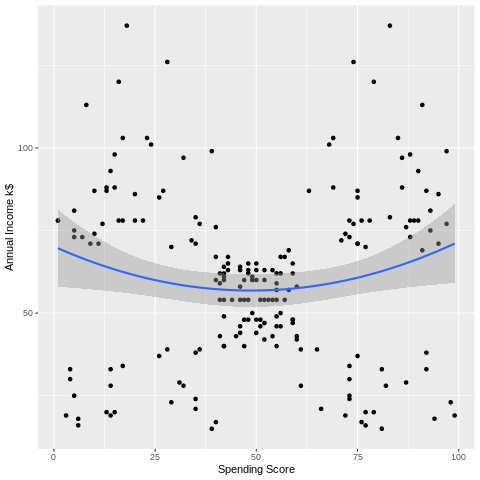

In [ ]:
%%R
ggplot(df, aes(x=df$Spending.Score..1.100., y=df$Annual.Income..k..)) +
          geom_point() +
          stat_smooth(method='lm', formula = y ~ poly(x,2), size = 1) +
          xlab('Spending Score') +
          ylab('Annual Income k$')

Как видим, разброс между полученным доходом и оценкой трат достаточно большой, но усреднение неплохое.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Untitled9.ipynb

[NbConvertApp] Converting notebook /content/Untitled9.ipynb to html
[NbConvertApp] Writing 1358806 bytes to /content/Untitled9.html
